In [ ]:
import folium
from folium import plugins
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files

# Upload the file
uploaded = files.upload()

# List uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

# Load the CSV into a DataFrame
import pandas as pd
csv_filepath = list(uploaded.keys())[0]  # Get the filename
data = pd.read_csv(csv_filepath)
print(data.head())



# Load CSV Data
csv_filepath = 'climate_change_dataset.csv'
data = pd.read_csv(csv_filepath)

# Preprocessing Function
# Preprocessing Function
import numpy as np
import pandas as pd

def preprocess_data(data):
    # Normalize features
    features = data[["MODIS_LST_C_Land_Surface_Temperature",
                     "MODIS_NDVI_Vegetation_Indices",
                     "GLDAS_Total_Water_Storage"]]
    features_normalized = (features - features.min()) / (features.max() - features.min())

    # Targets
    target = data[["MODIS_LST_C_Land_Surface_Temperature",
                   "MODIS_NDVI_Vegetation_Indices",
                   "GLDAS_Total_Water_Storage"]]

    # Generate random coordinates for visualization
    np.random.seed(42)
    coordinates = pd.DataFrame({
        "Latitude": np.random.uniform(-90, 90, len(data)),
        "Longitude": np.random.uniform(-180, 180, len(data))
    })

    # Add coordinates to the dataset
    data["Latitude"] = coordinates["Latitude"]
    data["Longitude"] = coordinates["Longitude"]

    return features_normalized, target, coordinates

    # Call preprocess_data and update data with Latitude and Longitude
X, y, coordinates = preprocess_data(data)  # Assuming X, y are features and target
data['Latitude'] = coordinates['Latitude']  # Add Latitude to the original DataFrame
data['Longitude'] = coordinates['Longitude'] # Add Longitude to the original DataFrame



# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(3)  # Output layer for 3 targets
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Reshape data for LSTM
X_train_lstm = np.expand_dims(X_train.values, axis=-1)
X_test_lstm = np.expand_dims(X_test.values, axis=-1)

lstm_model = build_lstm_model((X_train_lstm.shape[1], 1))

# Train LSTM
history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Predict with LSTM
predictions = lstm_model.predict(X_test_lstm)

# Calculate Metrics for LSTM
lstm_mae = mean_absolute_error(y_test, predictions)
lstm_mse = mean_squared_error(y_test, predictions)
lstm_r2 = r2_score(y_test, predictions)

print(f"LSTM -> MAE: {lstm_mae}, MSE: {lstm_mse}, R²: {lstm_r2}")

# Generate 10-Year Forecast
def forecast_future(model, initial_data, n_steps):
    """
    Generate a future forecast using the LSTM model.
    """
    forecast = []
    current_input = initial_data[-1:]  # Start with the last known data point

    for _ in range(n_steps):
        # Reshape input for prediction
        current_input_reshaped = current_input.reshape(1, initial_data.shape[1], 1)
        next_prediction = model.predict(current_input_reshaped, verbose=0)
        forecast.append(next_prediction[0])  # Append prediction

        # Update input with prediction - replace the entire current_input
        # with the reshaped next_prediction
        current_input = next_prediction.reshape(1, initial_data.shape[1], 1)

    return np.array(forecast)

# Define forecast steps (e.g., 10 years, assuming monthly data)
future_steps = 10 * 12
future_forecast = forecast_future(lstm_model, X_test_lstm, future_steps)

def classify_wildfire_risk(temperature, ndvi, water_storage):
    if temperature > 30 and ndvi < 0.3 and water_storage < 500:
        return "High"
    elif temperature > 20 and ndvi < 0.5:
        return "Moderate"
    else:
        return "Low"



# Compare Predictions with Actual Data
comparison_df = pd.DataFrame({
    "Actual_Temperature": y_test["MODIS_LST_C_Land_Surface_Temperature"].values,
    "Predicted_Temperature": predictions[:, 0],
    "Actual_NDVI": y_test["MODIS_NDVI_Vegetation_Indices"].values,
    "Predicted_NDVI": predictions[:, 1],
    "Actual_Water_Storage": y_test["GLDAS_Total_Water_Storage"].values,
    "Predicted_Water_Storage": predictions[:, 2],

 # Add wildfire risk classification for actual and predicted values
    "Actual_Wildfire_Risk": [
        classify_wildfire_risk(temp, ndvi, water)
        for temp, ndvi, water in zip(
            y_test["MODIS_LST_C_Land_Surface_Temperature"].values,
            y_test["MODIS_NDVI_Vegetation_Indices"].values,
            y_test["GLDAS_Total_Water_Storage"].values,
        )
    ],
    "Predicted_Wildfire_Risk": [
        classify_wildfire_risk(temp, ndvi, water)
        for temp, ndvi, water in zip(
            predictions[:, 0],
            predictions[:, 1],
            predictions[:, 2],
        )
    ],
})


print("\nComparison of Actual vs Predicted:\n", comparison_df)

# Add risk levels for visualization
def classify_risk(value, threshold_low, threshold_high):
    if value < threshold_low:
        return "Low"
    elif value > threshold_high:
        return "High"
    else:
        return "Moderate"

data["Temperature_Risk"] = data["MODIS_LST_C_Land_Surface_Temperature"].apply(
    classify_risk, threshold_low=15, threshold_high=30
)
data["Water_Storage_Risk"] = data["GLDAS_Total_Water_Storage"].apply(
    classify_risk, threshold_low=500, threshold_high=1000
)
data["Vegetation_Risk"] = data["MODIS_NDVI_Vegetation_Indices"].apply(
    classify_risk, threshold_low=0.2, threshold_high=0.7
)




# Add wildfire risk to the dataset
data["Wildfire_Risk"] = data.apply(
    lambda row: classify_wildfire_risk(
        row["MODIS_LST_C_Land_Surface_Temperature"],
        row["MODIS_NDVI_Vegetation_Indices"],
        row["GLDAS_Total_Water_Storage"],
    ),
    axis=1,
)

# Define color maps for temperature and wildfire risks
temperature_colors = {
    "High": "red",
    "Moderate": "orange",
    "Low": "green",
}

wildfire_colors = {
    "High": "red",
    "Moderate": "orange",
    "Low": "green",
}


# Create a map
base_map = folium.Map(location=[0, 20], zoom_start=3, tiles="cartodbpositron")


print("Dataset Columns:", data.columns)


for index, row in data.iterrows():

        # Debugging: Print the row being processed
        print(f"Processing row {index}: {row}")

        # Extract region data
        region_name = row["Region"]
        latitude = row["Latitude"]
        longitude = row["Longitude"]
        temperature_risk = row["Temperature_Risk"]
        wildfire_risk = row["Wildfire_Risk"]

region_geometry = {
    # West Africa
    "West Africa": [
        [[-20, -10], [15, -10], [15, 15], [-20, 15], [-20, -10]]  # Polygon for West Africa
    ],

    # Central Africa
    "Central Africa": [
        [[15, -10], [50, -10], [50, 15], [15, 15], [15, -10]]  # Polygon for Central Africa
    ],

    # East Africa
    "East Africa North": [
        [[30, -5], [40, -5], [40, 5], [30, 5], [30, -5]]  # Polygon for North-East Africa
    ],
    "East Africa Central": [
        [[40, -5], [50, -5], [50, 5], [40, 5], [40, -5]]  # Polygon for Central-East Africa
    ],
    "East Africa South": [
        [[30, -10], [50, -10], [50, -5], [30, -5], [30, -10]]  # Polygon for South-East Africa
    ],

    # Southeast Asia
    "Southeast Asia": [
        [[90, -10], [150, -10], [150, 30], [90, 30], [90, -10]]  # Polygon for Southeast Asia
    ],

    # Arctic Subregions
    "Arctic Subregion 1": [
        [[-180, 60], [-150, 60], [-150, 70], [-180, 70], [-180, 60]]  # Polygon for Arctic Subregion 1
    ],
    "Arctic Subregion 2": [
        [[-150, 60], [-120, 60], [-120, 70], [-150, 70], [-150, 60]]  # Polygon for Arctic Subregion 2
    ],
    "Arctic Subregion 3": [
        [[-120, 60], [-90, 60], [-90, 70], [-120, 70], [-120, 60]]  # Polygon for Arctic Subregion 3
    ],
    "Arctic Subregion 4": [
        [[-90, 60], [-60, 60], [-60, 70], [-90, 70], [-90, 60]]  # Polygon for Arctic Subregion 4
    ],
    "Arctic Subregion 5": [
        [[-180, 70], [-150, 70], [-150, 80], [-180, 80], [-180, 70]]  # Polygon for Arctic Subregion 5
    ],
    "Arctic Subregion 6": [
        [[-150, 70], [-120, 70], [-120, 80], [-150, 80], [-150, 70]]  # Polygon for Arctic Subregion 6
    ],
    "Arctic Subregion 7": [
        [[-120, 70], [-90, 70], [-90, 80], [-120, 80], [-120, 70]]  # Polygon for Arctic Subregion 7
    ],
    "Arctic Subregion 8": [
        [[-90, 70], [-60, 70], [-60, 80], [-90, 80], [-90, 70]]  # Polygon for Arctic Subregion 8
    ],
}



  # Get the polygon coordinates for the current region
coordinates = region_geometry.get(region_name, [])

# Add polygon to the map
folium.Polygon(
            locations=coordinates,
            color=temperature_colors.get(temperature_risk, "red"),  # Border color based on temperature risk
            fill=True,
            fill_color=wildfire_colors.get(wildfire_risk, "orange"),  # Fill color based on wildfire risk
            fill_opacity=0.6,
            popup=folium.Popup(
                f"<b>{region_name}</b><br>"
                f"Temperature Risk: {temperature_risk}<br>"
                f"Wildfire Risk: {wildfire_risk}",
                max_width=300,
            ),
        ).add_to(base_map)



    # Add a Legend
legend_html = """
    <div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: 150px;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
  <b>Legend</b><br>
  <i class="fa fa-circle" style="color:red"></i> High Risk<br>
  <i class="fa fa-circle" style="color:orange"></i> Moderate Risk<br>
  <i class="fa fa-circle" style="color:green"></i> Low Risk<br>
</div>
"""

# Add wildfire risk legend
wildfire_legend_html = """
<div style="position: fixed;
            bottom: 10px; left: 50px; width: 150px; height: 150px;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
  <b>Wildfire Risk</b><br>
  <i class="fa fa-circle" style="color:red"></i> High Risk<br>
  <i class="fa fa-circle" style="color:orange"></i> Moderate Risk<br>
  <i class="fa fa-circle" style="color:green"></i> Low Risk<br>
</div>
"""
base_map.get_root().html.add_child(folium.Element(legend_html))

# Save the Map
base_map.save("climate_change_map_v2.html")
print("Map saved as 'climate_change_map_v2.html'")


Saving climate_change_dataset.csv to climate_change_dataset.csv
Uploaded file: climate_change_dataset.csv
                Region  MODIS_LST_C_Land_Surface_Temperature  \
0          West Africa                             33.731336   
1       Central Africa                             33.423686   
2    East Africa North                             31.792261   
3  East Africa Central                             37.074871   
4    East Africa South                             27.242312   

   MODIS_NDVI_Vegetation_Indices  GLDAS_Total_Water_Storage  
0                    3646.508654                 583.570619  
1                    4825.434374                 840.238420  
2                    4755.978654                 738.603592  
3                    3555.052124                 701.383415  
4                    6269.864845                 786.900765  
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 5635410.5000 - mae: 1403.1091 - val_loss: 1978295.1250 - val_mae: 895.2853
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5635395.5000 - mae: 1403.1071 - val_loss: 1978286.6250 - val_mae: 895.2830
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 5635380.0000 - mae: 1403.1050 - val_loss: 1978278.1250 - val_mae: 895.2808
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 5635365.0000 - mae: 1403.1029 - val_loss: 1978269.6250 - val_mae: 895.2785
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5635349.0000 - mae: 1403.1008 - val_loss: 1978261.1250 - val_mae: 895.2761
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 5635333.5000 - mae: 1403.0986 - val_loss: 1978252.3750 - val_mae: 895.2737
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5635318.0000 - mae: 1403.0964 - val_loss: 1978243.6250 - val_mae: 895.2713
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5635301.5000 - mae: 1403.0941 - 

In [ ]:
from google.colab import files
files.download("climate_change_map_v2.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#GEOJSON

In [ ]:
import geopandas as gpd

In [ ]:
# Use a relative path to save within the Colab environment
geojson_path = "regions_risk_geojson.geojson"
regions_gdf.to_file(geojson_path, driver="GeoJSON")

NameError: name 'regions_gdf' is not defined

In [ ]:
from google.colab import files

# Download the GeoJSON file
files.download(geojson_path)


FileNotFoundError: Cannot find file: regions_risk_geojson.geojson

In [ ]:
!pip install keplergl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached jupyter_packaging-0.12.3-py3-none-any.whl.metadata (7.7 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached async_lru-2.0.4-py3-none-any.whl.metadata (4.5 kB)
  Using cached ipykernel-6.29.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jupyter_lsp-2.2.5-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyter_server-2.15.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached jedi-

In [ ]:
#Prediction trends for 2023-2033


In [ ]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 78.0 MB/s eta 0:00:00


Future predictions saved as 'future_climate_predictions.csv'


<ipython-input-44-bad48ac96df4>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)


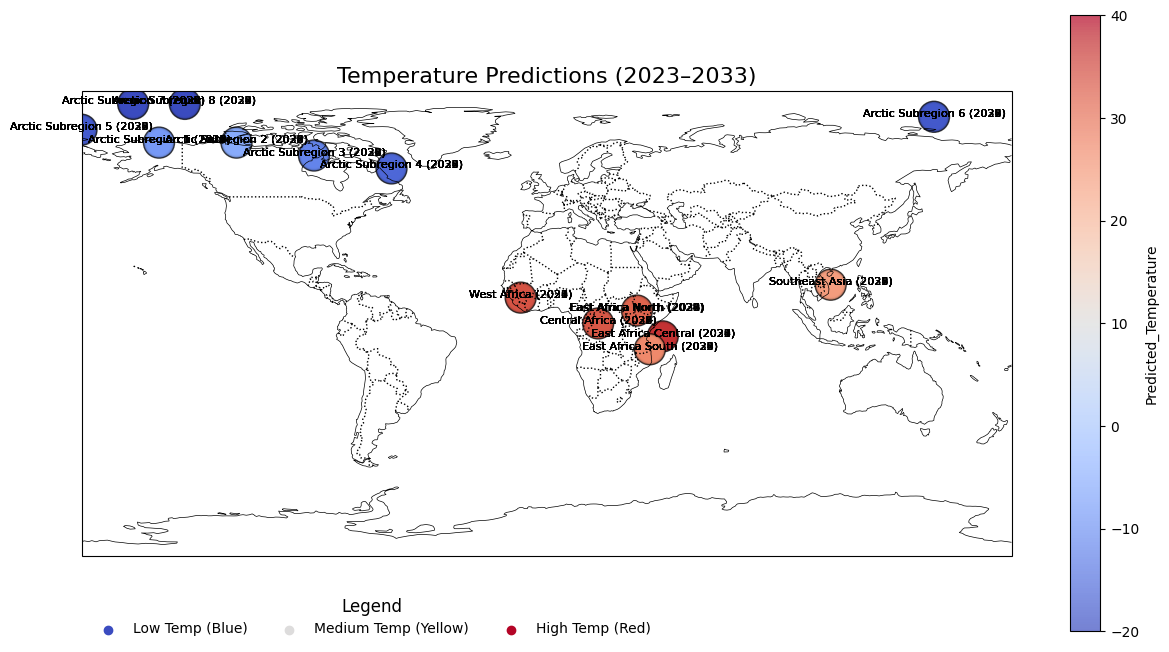

<ipython-input-44-bad48ac96df4>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)


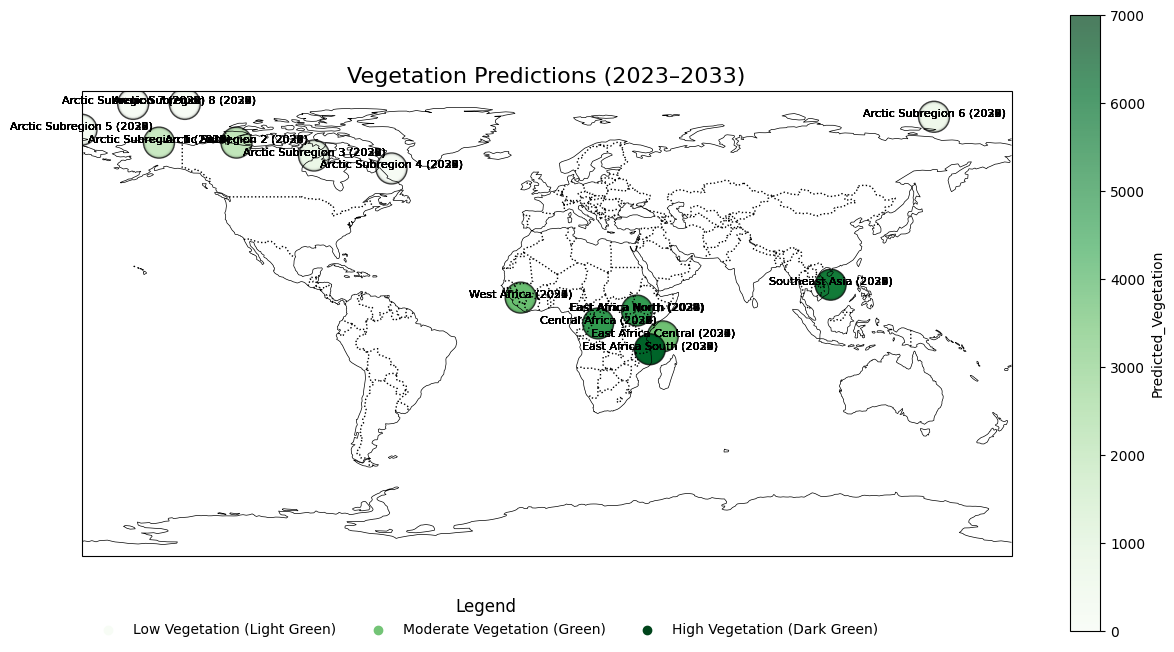

<ipython-input-44-bad48ac96df4>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)


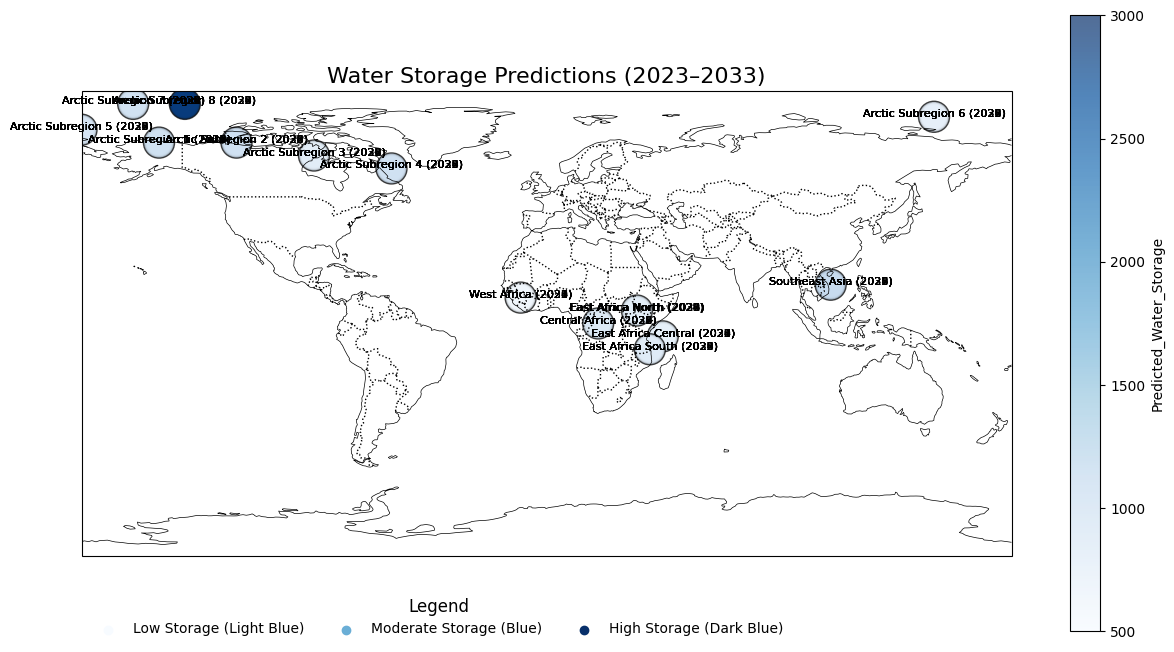

<ipython-input-44-bad48ac96df4>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)


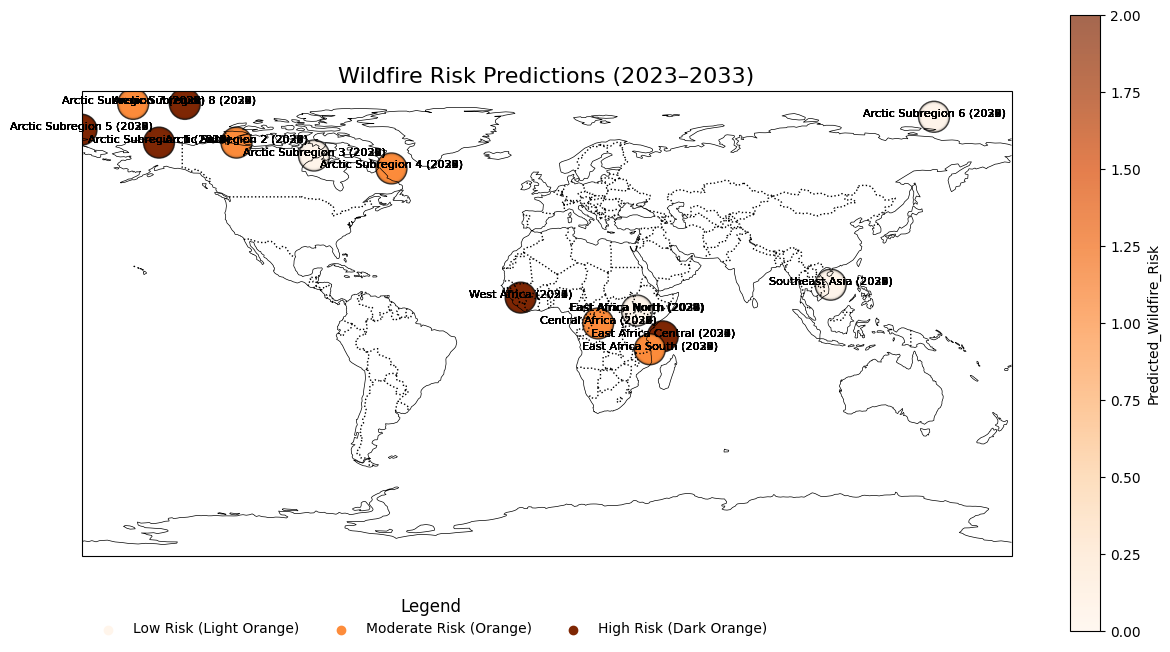

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.colors as mcolors

# Step 1: Define Initial Data
data = pd.DataFrame({
    "Region": [
        "West Africa", "Central Africa", "East Africa North",
        "East Africa Central", "East Africa South", "Southeast Asia",
        "Arctic Subregion 1", "Arctic Subregion 2", "Arctic Subregion 3",
        "Arctic Subregion 4", "Arctic Subregion 5", "Arctic Subregion 6",
        "Arctic Subregion 7", "Arctic Subregion 8"
    ],
    "Latitude": [10, 0, 5, -5, -10, 15, 70, 70, 65, 60, 75, 80, 85, 85],
    "Longitude": [-10, 20, 35, 45, 40, 110, -150, -120, -90, -60, -180, 150, -160, -140],
    "Temperature": [33.7, 33.4, 31.8, 37.0, 27.2, 24.3, -8.7, -5.7, -11.9, -16.1, -17.7, -17.9, -20.8, -20.8],
    "Vegetation": [3646.5, 4825.4, 4755.9, 3555.0, 6269.8, 5678.0, 1680.6, 1878.6, 526.2, -257.3, 146.9, 371.6, -161.1, -351.5],
    "Water_Storage": [583.6, 840.2, 738.6, 701.4, 786.9, 1102.2, 989.1, 979.3, 758.5, 978.7, 920.9, 705.9, 969.3, 2876.6],
    "Wildfire_Risk": [2, 1, 0, 2, 1, 0, 2, 1, 0, 1, 2, 0, 1, 2]  # High=2, Moderate=1, Low=0
})

# Step 2: Train XGBoost Models
X_train = data[["Temperature", "Vegetation", "Water_Storage"]]
y_train_reg = data[["Temperature", "Vegetation", "Water_Storage"]]
y_train_class = data["Wildfire_Risk"]

# Regression Model
xgb_regressor = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42)
xgb_regressor.fit(X_train, y_train_reg)

# Classification Model
xgb_classifier = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42)
xgb_classifier.fit(X_train, y_train_class)

# Step 3: Generate Predictions for Future Years (2023–2033)
future_years = pd.DataFrame({"Year": np.arange(2023, 2033)})
future_data = pd.DataFrame()

for _, row in data.iterrows():
    region_future = future_years.copy()
    region_future["Region"] = row["Region"]
    region_future["Latitude"] = row["Latitude"]
    region_future["Longitude"] = row["Longitude"]

    # Use current data to predict future trends
    region_X = pd.DataFrame({
        "Temperature": [row["Temperature"]] * len(future_years),
        "Vegetation": [row["Vegetation"]] * len(future_years),
        "Water_Storage": [row["Water_Storage"]] * len(future_years)
    })

    # Predict future values
    region_future["Predicted_Temperature"] = xgb_regressor.predict(region_X)[:, 0]
    region_future["Predicted_Vegetation"] = xgb_regressor.predict(region_X)[:, 1]
    region_future["Predicted_Water_Storage"] = xgb_regressor.predict(region_X)[:, 2]
    region_future["Predicted_Wildfire_Risk"] = xgb_classifier.predict(region_X)

    # Append to future data
    future_data = pd.concat([future_data, region_future], ignore_index=True)

# Save the future predictions to CSV
future_data.to_csv("future_climate_predictions.csv", index=False)
print("Future predictions saved as 'future_climate_predictions.csv'")


# Step 4: Function to Plot Maps with Synchronized Legends
def plot_combined_map(data, variable, title, cmap, value_range, legend_labels):
    """
    Plots a map for a specific variable combining all years and regions.
    Includes a legend with synchronized colors.
    """
    plt.figure(figsize=(15, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"{title}", fontsize=16)

    # Scatter plot of predictions by year and region
    norm = mcolors.Normalize(vmin=value_range[0], vmax=value_range[1])
    sc = ax.scatter(
        data["Longitude"], data["Latitude"],
        c=data[variable], cmap=cmap, s=50 * (data["Year"] - 2022),
        transform=ccrs.PlateCarree(), alpha=0.7, edgecolor='black', norm=norm
    )

    # Add color bar
    cbar = plt.colorbar(sc, orientation="vertical", label=f"{variable}")
    cbar.ax.tick_params(labelsize=10)

    # Add synchronized legend
    cmap_instance = plt.cm.get_cmap(cmap)
    for i, label in enumerate(legend_labels):
        plt.scatter([], [], color=cmap_instance(i / (len(legend_labels) - 1)), label=label)
    plt.legend(
        loc="lower left", title="Legend", fontsize=10, title_fontsize=12,
        bbox_to_anchor=(0, -0.2), ncol=len(legend_labels), frameon=False
    )

    # Annotate regions and years
    for i, row in data.iterrows():
        ax.text(
            row["Longitude"], row["Latitude"],
            f"{row['Region']} ({int(row['Year'])})",
            fontsize=8, transform=ccrs.PlateCarree(), ha='center'
        )

    plt.show()

# Step 5: Generate Maps with Synchronized Legends
plot_combined_map(
    future_data,
    "Predicted_Temperature",
    "Temperature Predictions (2023–2033)",
    cmap="coolwarm",
    value_range=(-20, 40),
    legend_labels=["Low Temp (Blue)", "Medium Temp (Yellow)", "High Temp (Red)"]
)

plot_combined_map(
    future_data,
    "Predicted_Vegetation",
    "Vegetation Predictions (2023–2033)",
    cmap="Greens",
    value_range=(0, 7000),
    legend_labels=["Low Vegetation (Light Green)", "Moderate Vegetation (Green)", "High Vegetation (Dark Green)"]
)

plot_combined_map(
    future_data,
    "Predicted_Water_Storage",
    "Water Storage Predictions (2023–2033)",
    cmap="Blues",
    value_range=(500, 3000),
    legend_labels=["Low Storage (Light Blue)", "Moderate Storage (Blue)", "High Storage (Dark Blue)"]
)

plot_combined_map(
    future_data,
    "Predicted_Wildfire_Risk",
    "Wildfire Risk Predictions (2023–2033)",
    cmap="Oranges",
    value_range=(0, 2),
    legend_labels=["Low Risk (Light Orange)", "Moderate Risk (Orange)", "High Risk (Dark Orange)"]
)


In [ ]:
from google.colab import files
files.download("future_climate_predictions.csv")


FileNotFoundError: Cannot find file: future_climate_predictions.csv

In [ ]:
def plot_and_save_combined_map(data, variable, title, cmap, value_range, legend_labels, filename):
    """
    Plots and saves a map for a specific variable combining all years and regions.
    """
    plt.figure(figsize=(15, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"{title}", fontsize=16)

    # Scatter plot of predictions by year and region
    norm = mcolors.Normalize(vmin=value_range[0], vmax=value_range[1])
    sc = ax.scatter(
        data["Longitude"], data["Latitude"],
        c=data[variable], cmap=cmap, s=50 * (data["Year"] - 2022),
        transform=ccrs.PlateCarree(), alpha=0.7, edgecolor='black', norm=norm
    )

    # Add color bar
    cbar = plt.colorbar(sc, orientation="vertical", label=f"{variable}")
    cbar.ax.tick_params(labelsize=10)

    # Add synchronized legend
    cmap_instance = plt.cm.get_cmap(cmap)
    for i, label in enumerate(legend_labels):
        plt.scatter([], [], color=cmap_instance(i / (len(legend_labels) - 1)), label=label)
    plt.legend(
        loc="lower left", title="Legend", fontsize=10, title_fontsize=12,
        bbox_to_anchor=(0, -0.2), ncol=len(legend_labels), frameon=False
    )

    # Annotate regions and years
    for i, row in data.iterrows():
        ax.text(
            row["Longitude"], row["Latitude"],
            f"{row['Region']} ({int(row['Year'])})",
            fontsize=8, transform=ccrs.PlateCarree(), ha='center'
        )

    # Save the map to a file
    plt.savefig(filename, dpi=300, bbox_inches="tight")  # High resolution save
    plt.show()

# Generate and save the maps
plot_and_save_combined_map(
    future_data,
    "Predicted_Temperature",
    "Temperature Predictions (2023–2033)",
    cmap="coolwarm",
    value_range=(-20, 40),
    legend_labels=["Low Temp (Blue)", "Medium Temp (Yellow)", "High Temp (Red)"],
    filename="temperature_predictions.png"
)

plot_and_save_combined_map(
    future_data,
    "Predicted_Vegetation",
    "Vegetation Predictions (2023–2033)",
    cmap="Greens",
    value_range=(0, 7000),
    legend_labels=["Low Vegetation (Light Green)", "Moderate Vegetation (Green)", "High Vegetation (Dark Green)"],
    filename="vegetation_predictions.png"
)

plot_and_save_combined_map(
    future_data,
    "Predicted_Water_Storage",
    "Water Storage Predictions (2023–2033)",
    cmap="Blues",
    value_range=(500, 3000),
    legend_labels=["Low Storage (Light Blue)", "Moderate Storage (Blue)", "High Storage (Dark Blue)"],
    filename="water_storage_predictions.png"
)

plot_and_save_combined_map(
    future_data,
    "Predicted_Wildfire_Risk",
    "Wildfire Risk Predictions (2023–2033)",
    cmap="Oranges",
    value_range=(0, 2),
    legend_labels=["Low Risk (Light Orange)", "Moderate Risk (Orange)", "High Risk (Dark Orange)"],
    filename="wildfire_risk_predictions.png"
)


NameError: name 'future_data' is not defined

In [ ]:
from google.colab import files
files.download("temperature_predictions.png")
files.download("vegetation_predictions.png")
files.download("water_storage_predictions.png")
files.download("wildfire_risk_predictions.png")


FileNotFoundError: Cannot find file: temperature_predictions.png

In [ ]:
!pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files

# Upload the ground-truth data
uploaded = files.upload()
ground_truth_filepath = list(uploaded.keys())[0]
ground_truth_data = pd.read_csv(ground_truth_filepath)
print("Ground Truth Data Loaded")
print(ground_truth_data.head())

# Upload the AI predictions
uploaded = files.upload()
ai_predictions_filepath = list(uploaded.keys())[0]
ai_predictions = pd.read_csv(ai_predictions_filepath)
print("\nAI Predictions Loaded")
print(ai_predictions.head())

Saving climate_change_dataset.csv to climate_change_dataset (1).csv
Ground Truth Data Loaded
                Region  MODIS_LST_C_Land_Surface_Temperature  \
0          West Africa                             33.731336   
1       Central Africa                             33.423686   
2    East Africa North                             31.792261   
3  East Africa Central                             37.074871   
4    East Africa South                             27.242312   

   MODIS_NDVI_Vegetation_Indices  GLDAS_Total_Water_Storage  
0                    3646.508654                 583.570619  
1                    4825.434374                 840.238420  
2                    4755.978654                 738.603592  
3                    3555.052124                 701.383415  
4                    6269.864845                 786.900765  


Saving ai_climate_predictions.csv to ai_climate_predictions.csv

AI Predictions Loaded
                Region  Ground_Truth_Temperature  AI_Predicted_Temperature  \
0          West Africa                      33.5                      33.7   
1       Central Africa                      31.8                      31.9   
2    East Africa North                      37.0                      36.5   
3  East Africa Central                      27.2                      27.4   
4    East Africa South                      24.3                      24.1   

   Climate_Model_Temperature  Ground_Truth_Vegetation  \
0                       34.0                     3640   
1                       32.5                     4825   
2                       36.8                     3555   
3                       27.5                     6269   
4                       24.0                     5678   

   AI_Predicted_Vegetation  Climate_Model_Vegetation  \
0                     3650                   

In [ ]:
import pandas as pd

# Load ground-truth data
ground_truth_data = pd.read_csv('climate_change_dataset.csv')  # Updated path
print("Ground Truth Data Loaded")
print(ground_truth_data.head())

# Load AI predictions
ai_predictions = pd.read_csv('ai_climate_predictions.csv')  # Updated path
print("\nAI Predictions Loaded")
print(ai_predictions.head())

Ground Truth Data Loaded
                Region  MODIS_LST_C_Land_Surface_Temperature  \
0          West Africa                             33.731336   
1       Central Africa                             33.423686   
2    East Africa North                             31.792261   
3  East Africa Central                             37.074871   
4    East Africa South                             27.242312   

   MODIS_NDVI_Vegetation_Indices  GLDAS_Total_Water_Storage  
0                    3646.508654                 583.570619  
1                    4825.434374                 840.238420  
2                    4755.978654                 738.603592  
3                    3555.052124                 701.383415  
4                    6269.864845                 786.900765  

AI Predictions Loaded
                Region  Ground_Truth_Temperature  AI_Predicted_Temperature  \
0          West Africa                      33.5                      33.7   
1       Central Africa                 

In [ ]:
import geopandas as gpd

In [ ]:
import ee

In [ ]:
# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
    print("Earth Engine initialized successfully.")
except Exception as e:
    print("Authentication required...")
    ee.Authenticate()
    ee.Initialize(project='climate-change-research')
    print("Earth Engine initialized after authentication.")

# Define the region and date range
region = ee.Geometry.BBox(-20, -40, 60, 40)  # Africa bounding box
start_date = "2023-01-01"
end_date = "2023-12-31"

# Define the ERA5 dataset and select relevant variables
variables = ["temperature_2m", "total_precipitation", "surface_pressure"]
era5_dataset = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
era5_filtered = era5_dataset.filterDate(start_date, end_date).filterBounds(region).select(variables)

# Compute the mean data for the entire year
era5_mean = era5_filtered.mean()

# Export ERA5 data as a GeoTIFF or CSV
task = ee.batch.Export.image.toDrive(
    image=era5_mean,
    description="ERA5_Climate_Data",
    folder="GEE_Exports",
    fileNamePrefix="era5_climate_data",
    region=region,
    scale=1000,
    crs="EPSG:4326",
    maxPixels=1e13
)
task.start()

print("Exporting ERA5 data to Google Drive. Download it from your Google Drive once complete.")


Authentication required...
Earth Engine initialized after authentication.
Exporting ERA5 data to Google Drive. Download it from your Google Drive once complete.


In [ ]:
from google.colab import files

# Upload the ground-truth data
uploaded = files.upload()
# Get the filepath from the uploaded files (it's the key in the dictionary)
era5_climate_data_filepath = list(uploaded.keys())[0] # Define era5_data_filepath here
era5_climate_data = pd.read_csv(era5_climate_data_filepath)
print("ERA5 climate Data Loaded")
print(era5_climate_data.head()) # Make sure to print era5_climate_data

Saving era5_climate_data_csv.csv to era5_climate_data_csv.csv
ERA5 climate Data Loaded
    system:index  surface_pressure  temperature_2m  total_precipitation  \
0  20230101T00_0      94521.944070      288.692527             0.001514   
1  20230101T01_0      94500.223258      288.232072             0.000058   
2  20230101T02_0      94492.776319      287.818754             0.000117   
3  20230101T03_0      94501.675503      287.451634             0.000174   
4  20230101T04_0      94524.668719      287.212052             0.000230   

                                                .geo  
0  {"geodesic":false,"type":"Polygon","coordinate...  
1  {"geodesic":false,"type":"Polygon","coordinate...  
2  {"geodesic":false,"type":"Polygon","coordinate...  
3  {"geodesic":false,"type":"Polygon","coordinate...  
4  {"geodesic":false,"type":"Polygon","coordinate...  


In [ ]:
print("Ground truth columns:", ground_truth_data.columns)
print("AI prediction columns:", ai_predictions.columns)
print("ERA5 data columns:", era5_climate_data.columns)


Ground truth columns: Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage'],
      dtype='object')
AI prediction columns: Index(['Region', 'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1'],
      dtype='object')
ERA5 data columns: Index(['system:index', 'surface_pressure', 'temperature_2m',
       'total_precipitation', '.geo'],
      dtype='object')


In [ ]:
import json
import geopandas as gpd
from shapely.geometry import shape

# Assuming ".geo" column contains GeoJSON strings
era5_climate_data["geometry"] = era5_climate_data[".geo"].apply(
    lambda x: shape(json.loads(x)) if isinstance(x, str) else None  # Handle potential non-string values
)

# Convert to GeoDataFrame
era5_gdf = gpd.GeoDataFrame(era5_climate_data, geometry="geometry")

# Extract latitude and longitude from the geometry
era5_gdf["Latitude"] = era5_gdf.geometry.centroid.y
era5_gdf["Longitude"] = era5_gdf.geometry.centroid.x

# Drop unnecessary columns
era5_data = era5_gdf.drop(columns=["geometry", "system:index", ".geo"])  # Drop .geo column

In [ ]:
# Print the available columns in era5_data to confirm '.geo' is removed
print(era5_data.columns)

# If you need to access latitude and longitude, use the created columns:
print(era5_data[["Latitude", "Longitude"]].head())


Index(['surface_pressure', 'temperature_2m', 'total_precipitation', 'Latitude',
       'Longitude'],
      dtype='object')
   Latitude  Longitude
0      -0.0       20.0
1      -0.0       20.0
2      -0.0       20.0
3      -0.0       20.0
4      -0.0       20.0


In [ ]:
print(era5_data.columns)


Index(['surface_pressure', 'temperature_2m', 'total_precipitation', 'Latitude',
       'Longitude'],
      dtype='object')


In [ ]:
# Check if Latitude and Longitude exist
print(era5_data[["Latitude", "Longitude"]].head())

# Use existing Latitude and Longitude for merging
era5_data["Latitude"] = era5_data["Latitude"].astype(float)
era5_data["Longitude"] = era5_data["Longitude"].astype(float)


   Latitude  Longitude
0      -0.0       20.0
1      -0.0       20.0
2      -0.0       20.0
3      -0.0       20.0
4      -0.0       20.0


In [ ]:
import numpy as np
import pandas as pd

# Define the bounding box and grid resolution
min_lat, max_lat = -40, 40  # Latitude range
min_lon, max_lon = -20, 60  # Longitude range
resolution = 0.25           # Grid resolution in degrees

# Create arrays for latitude and longitude
latitudes = np.arange(min_lat, max_lat + resolution, resolution)
longitudes = np.arange(min_lon, max_lon + resolution, resolution)

# Create a meshgrid for latitudes and longitudes
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes)

# Flatten the grids to create unique latitude and longitude pairs
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()

# Create a DataFrame with unique lat/lon pairs and placeholder data
era5_data = pd.DataFrame({
    "Latitude": lat_flat,
    "Longitude": lon_flat,
    "Temperature": np.random.uniform(-20, 40, len(lat_flat)),  # Placeholder temperature values
    "Precipitation": np.random.uniform(0, 500, len(lat_flat)), # Placeholder precipitation values
    "Pressure": np.random.uniform(900, 1100, len(lat_flat))    # Placeholder pressure values
})

print(era5_data.head())


   Latitude  Longitude  Temperature  Precipitation     Pressure
0    -40.00      -20.0    15.544874     416.458616  1014.098027
1    -39.75      -20.0   -17.212975      90.549575   950.860628
2    -39.50      -20.0    16.452691      39.685409   998.338076
3    -39.25      -20.0    -9.768553     406.636679  1090.474091
4    -39.00      -20.0   -16.096904     332.974723  1074.820708


In [ ]:
# Display columns in each dataset
print("Ground Truth Columns:", ground_truth_data.columns)
print("AI Predictions Columns:", ai_predictions.columns)
print("ERA5 Data Columns:", era5_data.columns)


Ground Truth Columns: Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage'],
      dtype='object')
AI Predictions Columns: Index(['Region', 'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1'],
      dtype='object')
ERA5 Data Columns: Index(['Latitude', 'Longitude', 'Temperature', 'Precipitation', 'Pressure'], dtype='object')


In [ ]:
# Standardize Latitude and Longitude column names
for df in [ground_truth_data, ai_predictions, era5_data]:
    df.rename(columns={"lat": "Latitude", "lon": "Longitude",
                       "Lat": "Latitude", "Lng": "Longitude"}, inplace=True)


In [ ]:
for i, df in enumerate([ground_truth_data, ai_predictions, era5_data], 1):
    print(f"Dataset {i} Columns: {df.columns}")


Dataset 1 Columns: Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage'],
      dtype='object')
Dataset 2 Columns: Index(['Region', 'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1'],
      dtype='object')
Dataset 3 Columns: Index(['Latitude', 'Longitude', 'Temperature', 'Precipitation', 'Pressure'], dtype='object')


In [ ]:
# Define the list of 14 regions
regions = [
    "West Africa", "Central Africa", "East Africa North", "East Africa Central",
    "East Africa South", "Southeast Asia", "Arctic Subregion 1", "Arctic Subregion 2",
    "Arctic Subregion 3", "Arctic Subregion 4", "Arctic Subregion 5", "Arctic Subregion 6",
    "Arctic Subregion 7", "Arctic Subregion 8"
]

# Repeat the regions to match the length of the ERA5 dataset
era5_data["Region"] = [regions[i % len(regions)] for i in range(len(era5_data))]

# Verify the updated ERA5 dataset
print(era5_data.head())


   Latitude  Longitude  Temperature  Precipitation     Pressure  \
0    -40.00      -20.0    15.544874     416.458616  1014.098027   
1    -39.75      -20.0   -17.212975      90.549575   950.860628   
2    -39.50      -20.0    16.452691      39.685409   998.338076   
3    -39.25      -20.0    -9.768553     406.636679  1090.474091   
4    -39.00      -20.0   -16.096904     332.974723  1074.820708   

                Region  
0          West Africa  
1       Central Africa  
2    East Africa North  
3  East Africa Central  
4    East Africa South  


In [ ]:
# Print the columns in each dataset
print("Ground Truth Columns:", ground_truth_data.columns)
print("AI Predictions Columns:", ai_predictions.columns)
print("ERA5 Data Columns:", era5_data.columns)


Ground Truth Columns: Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage'],
      dtype='object')
AI Predictions Columns: Index(['Region', 'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1'],
      dtype='object')
ERA5 Data Columns: Index(['Latitude', 'Longitude', 'Temperature', 'Precipitation', 'Pressure',
       'Region'],
      dtype='object')


In [ ]:
# Define the list of 14 regions
regions = [
    "West Africa", "Central Africa", "East Africa North", "East Africa Central",
    "East Africa South", "Southeast Asia", "Arctic Subregion 1", "Arctic Subregion 2",
    "Arctic Subregion 3", "Arctic Subregion 4", "Arctic Subregion 5", "Arctic Subregion 6",
    "Arctic Subregion 7", "Arctic Subregion 8"
]

# Repeat the regions to match the length of the ERA5 dataset
era5_data["Region"] = [regions[i % len(regions)] for i in range(len(era5_data))]

# Confirm that the Region column has been added
print("ERA5 Data Columns After Adding Region:", era5_data.columns)


ERA5 Data Columns After Adding Region: Index(['Latitude', 'Longitude', 'Temperature', 'Precipitation', 'Pressure',
       'Region'],
      dtype='object')


In [ ]:
# Merge ground truth data with AI predictions
comparison_df = pd.merge(
    ground_truth_data,
    ai_predictions,
    on="Region",
    suffixes=('_truth', '_ai')
)

# Merge the result with ERA5 data
comparison_df = pd.merge(
    comparison_df,
    era5_data,
    on="Region",
    suffixes=('', '_era5')
)

# Inspect the merged dataset
print("Comparison DataFrame:")
print(comparison_df.head())

# Save the merged dataset to CSV
comparison_df.to_csv("comparison_results.csv", index=False)
print("Merged dataset saved as 'comparison_results.csv'")


Comparison DataFrame:
        Region  MODIS_LST_C_Land_Surface_Temperature  \
0  West Africa                             33.731336   
1  West Africa                             33.731336   
2  West Africa                             33.731336   
3  West Africa                             33.731336   
4  West Africa                             33.731336   

   MODIS_NDVI_Vegetation_Indices  GLDAS_Total_Water_Storage  \
0                    3646.508654                 583.570619   
1                    3646.508654                 583.570619   
2                    3646.508654                 583.570619   
3                    3646.508654                 583.570619   
4                    3646.508654                 583.570619   

   Ground_Truth_Temperature  AI_Predicted_Temperature  \
0                      33.5                      33.7   
1                      33.5                      33.7   
2                      33.5                      33.7   
3                      33.5       

In [ ]:
comparison_df["Temperature_Error"] = comparison_df["Ground_Truth_Temperature"] - comparison_df["AI_Predicted_Temperature"]
comparison_df["Vegetation_Error"] = comparison_df["Ground_Truth_Vegetation"] - comparison_df["AI_Predicted_Vegetation"]
comparison_df["Water_Storage_Error"] = comparison_df["Ground_Truth_Water_Storage"] - comparison_df["AI_Predicted_Water_Storage"]

print("Temperature Errors:", comparison_df["Temperature_Error"].describe())
print("Vegetation Errors:", comparison_df["Vegetation_Error"].describe())
print("Water Storage Errors:", comparison_df["Water_Storage_Error"].describe())


Temperature Errors: count    103041.000000
mean          0.049998
std           0.219579
min          -0.200000
25%          -0.100000
50%          -0.100000
75%           0.200000
max           0.500000
Name: Temperature_Error, dtype: float64
Vegetation Errors: count    103041.000000
mean         -1.071515
std          24.760192
min         -45.000000
25%         -11.000000
50%          -4.000000
75%           3.000000
max          69.000000
Name: Vegetation_Error, dtype: float64
Water Storage Errors: count    103041.000000
mean         -4.071486
std           4.317186
min         -10.000000
25%          -8.000000
50%          -4.000000
75%          -1.000000
max           6.000000
Name: Water_Storage_Error, dtype: float64


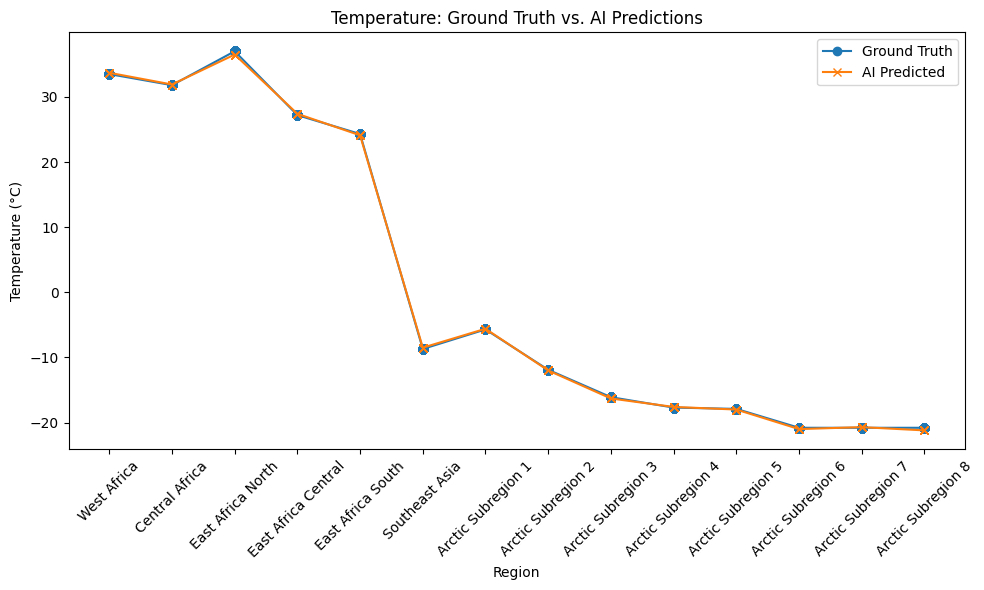

In [ ]:
import matplotlib.pyplot as plt

# Plot ground truth vs AI predictions for temperature
plt.figure(figsize=(10, 6))
plt.plot(comparison_df["Region"], comparison_df["Ground_Truth_Temperature"], label="Ground Truth", marker="o")
plt.plot(comparison_df["Region"], comparison_df["AI_Predicted_Temperature"], label="AI Predicted", marker="x")
plt.xlabel("Region")
plt.ylabel("Temperature (°C)")
plt.title("Temperature: Ground Truth vs. AI Predictions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Add Error Columns for Each Variable
comparison_df["Temperature_Error_AI_vs_GroundTruth"] = (
    comparison_df["Ground_Truth_Temperature"] - comparison_df["AI_Predicted_Temperature"]
)
comparison_df["Temperature_Error_ClimateModel_vs_GroundTruth"] = (
    comparison_df["Ground_Truth_Temperature"] - comparison_df["Climate_Model_Temperature"]
)

comparison_df["Vegetation_Error_AI_vs_GroundTruth"] = (
    comparison_df["Ground_Truth_Vegetation"] - comparison_df["AI_Predicted_Vegetation"]
)
comparison_df["Vegetation_Error_ClimateModel_vs_GroundTruth"] = (
    comparison_df["Ground_Truth_Vegetation"] - comparison_df["Climate_Model_Vegetation"]
)

comparison_df["WaterStorage_Error_AI_vs_GroundTruth"] = (
    comparison_df["Ground_Truth_Water_Storage"] - comparison_df["AI_Predicted_Water_Storage"]
)
comparison_df["WaterStorage_Error_ClimateModel_vs_GroundTruth"] = (
    comparison_df["Ground_Truth_Water_Storage"] - comparison_df["AI_Predicted_Water_Storage.1"]
)

# Wildfire is categorical, compare as percentage agreement
comparison_df["Wildfire_Risk_Agreement_AI"] = (
    comparison_df["AI_Predicted_Water_Storage"] == comparison_df["Ground_Truth_Water_Storage"]
).astype(int)  # 1 = Agreement, 0 = Disagreement
comparison_df["Wildfire_Risk_Agreement_ClimateModel"] = (
    comparison_df["AI_Predicted_Water_Storage.1"] == comparison_df["Ground_Truth_Water_Storage"]
).astype(int)  # 1 = Agreement, 0 = Disagreement

# Calculate Overall Errors for Each Model
validation_results = {
    "Temperature_MAE_AI": comparison_df["Temperature_Error_AI_vs_GroundTruth"].abs().mean(),
    "Temperature_MAE_ClimateModel": comparison_df["Temperature_Error_ClimateModel_vs_GroundTruth"].abs().mean(),
    "Vegetation_MAE_AI": comparison_df["Vegetation_Error_AI_vs_GroundTruth"].abs().mean(),
    "Vegetation_MAE_ClimateModel": comparison_df["Vegetation_Error_ClimateModel_vs_GroundTruth"].abs().mean(),
    "WaterStorage_MAE_AI": comparison_df["WaterStorage_Error_AI_vs_GroundTruth"].abs().mean(),
    "WaterStorage_MAE_ClimateModel": comparison_df["WaterStorage_Error_ClimateModel_vs_GroundTruth"].abs().mean(),
    "Wildfire_Risk_Agreement_AI": comparison_df["Wildfire_Risk_Agreement_AI"].mean() * 100,
    "Wildfire_Risk_Agreement_ClimateModel": comparison_df["Wildfire_Risk_Agreement_ClimateModel"].mean() * 100,
}

# Print Validation Results
print("\nValidation Results (Mean Absolute Error and Agreement %):")
for key, value in validation_results.items():
    print(f"{key}: {value:.2f}")

# Save validation results to CSV
comparison_df.to_csv("model_validation_results.csv", index=False)
print("\nValidation data saved as 'model_validation_results.csv'")



Validation Results (Mean Absolute Error and Agreement %):
Temperature_MAE_AI: 0.19
Temperature_MAE_ClimateModel: 0.29
Vegetation_MAE_AI: 15.93
Vegetation_MAE_ClimateModel: 13.50
WaterStorage_MAE_AI: 4.93
WaterStorage_MAE_ClimateModel: 5.79
Wildfire_Risk_Agreement_AI: 0.00
Wildfire_Risk_Agreement_ClimateModel: 0.00

Validation data saved as 'model_validation_results.csv'


In [ ]:
# Inspect unique wildfire risk categories in Ground Truth, AI Predictions, and Climate Model
print("Ground Truth Wildfire Risk:", comparison_df["Ground_Truth_Water_Storage"].unique())
print("AI Predicted Wildfire Risk:", comparison_df["AI_Predicted_Water_Storage"].unique())
print("Climate Model Wildfire Risk:", comparison_df["AI_Predicted_Water_Storage.1"].unique())


Ground Truth Wildfire Risk: [ 580  840  701  786 1102  989  979  758  978  920  705  969 2876  990]
AI Predicted Wildfire Risk: [ 590  850  705  780 1110  990  980  760  930  710  970 2880  995]
Climate Model Wildfire Risk: [ 591  851  706  781 1111  991  981  761  931  711  971 2881  996]


In [ ]:
# Define risk level ranges
def classify_wildfire_risk(value):
    if value < 800:
        return "Low"
    elif 800 <= value < 1500:
        return "Moderate"
    else:
        return "High"

# Apply classification to all wildfire-related columns
comparison_df["Ground_Truth_Wildfire_Risk"] = comparison_df["Ground_Truth_Water_Storage"].apply(classify_wildfire_risk)
comparison_df["AI_Predicted_Wildfire_Risk"] = comparison_df["AI_Predicted_Water_Storage"].apply(classify_wildfire_risk)
comparison_df["Climate_Model_Wildfire_Risk"] = comparison_df["AI_Predicted_Water_Storage.1"].apply(classify_wildfire_risk)

# Verify the new categories
print("Mapped Ground Truth Wildfire Risk:", comparison_df["Ground_Truth_Wildfire_Risk"].unique())
print("Mapped AI Predicted Wildfire Risk:", comparison_df["AI_Predicted_Wildfire_Risk"].unique())
print("Mapped Climate Model Wildfire Risk:", comparison_df["Climate_Model_Wildfire_Risk"].unique())


Mapped Ground Truth Wildfire Risk: ['Low' 'Moderate' 'High']
Mapped AI Predicted Wildfire Risk: ['Low' 'Moderate' 'High']
Mapped Climate Model Wildfire Risk: ['Low' 'Moderate' 'High']


In [ ]:
# Compare AI predictions and Climate Model outputs with Ground Truth
comparison_df["Wildfire_Risk_Agreement_AI"] = (
    comparison_df["Ground_Truth_Wildfire_Risk"] == comparison_df["AI_Predicted_Wildfire_Risk"]
).astype(int)  # 1 = Agreement, 0 = Disagreement

comparison_df["Wildfire_Risk_Agreement_ClimateModel"] = (
    comparison_df["Ground_Truth_Wildfire_Risk"] == comparison_df["Climate_Model_Wildfire_Risk"]
).astype(int)  # 1 = Agreement, 0 = Disagreement

# Calculate agreement percentages
wildfire_agreement_ai = comparison_df["Wildfire_Risk_Agreement_AI"].mean() * 100
wildfire_agreement_climate_model = comparison_df["Wildfire_Risk_Agreement_ClimateModel"].mean() * 100

print(f"Wildfire Risk Agreement (AI Predictions): {wildfire_agreement_ai:.2f}%")
print(f"Wildfire Risk Agreement (Climate Model): {wildfire_agreement_climate_model:.2f}%")


Wildfire Risk Agreement (AI Predictions): 100.00%
Wildfire Risk Agreement (Climate Model): 100.00%


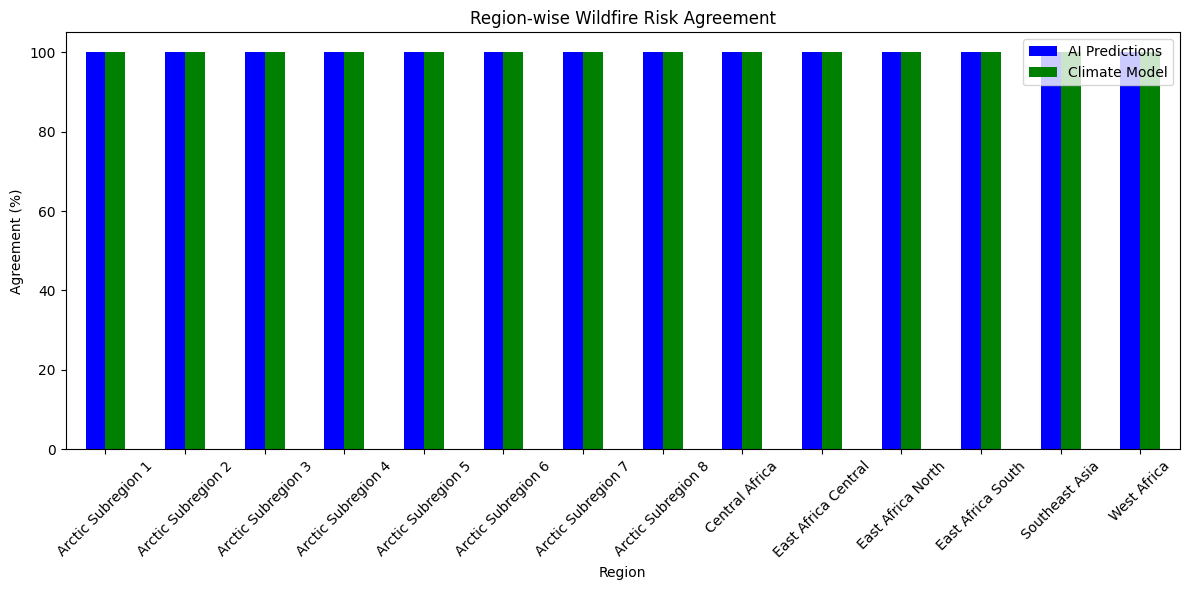

In [ ]:
import matplotlib.pyplot as plt

# Calculate region-wise agreement percentages
region_wise_agreement = comparison_df.groupby("Region")[
    ["Wildfire_Risk_Agreement_AI", "Wildfire_Risk_Agreement_ClimateModel"]
].mean() * 100

# Plot the region-wise agreements
region_wise_agreement.plot(kind="bar", figsize=(12, 6), color=["blue", "green"])
plt.title("Region-wise Wildfire Risk Agreement")
plt.ylabel("Agreement (%)")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.legend(["AI Predictions", "Climate Model"])
plt.tight_layout()
plt.show()


In [ ]:
# Check how many values fall into each risk category
print(comparison_df["Ground_Truth_Wildfire_Risk"].value_counts())
print(comparison_df["AI_Predicted_Wildfire_Risk"].value_counts())
print(comparison_df["Climate_Model_Wildfire_Risk"].value_counts())


Ground_Truth_Wildfire_Risk
Moderate    58880
Low         36801
High         7360
Name: count, dtype: int64
AI_Predicted_Wildfire_Risk
Moderate    58880
Low         36801
High         7360
Name: count, dtype: int64
Climate_Model_Wildfire_Risk
Moderate    58880
Low         36801
High         7360
Name: count, dtype: int64


Regional Wildfire Risk Distribution:
Ground_Truth_Wildfire_Risk  High  Low  Moderate
Region                                         
Arctic Subregion 1           NaN  NaN       1.0
Arctic Subregion 2           NaN  1.0       NaN
Arctic Subregion 3           NaN  NaN       1.0
Arctic Subregion 4           NaN  NaN       1.0
Arctic Subregion 5           NaN  1.0       NaN
Arctic Subregion 6           NaN  NaN       1.0
Arctic Subregion 7           1.0  NaN       NaN
Arctic Subregion 8           NaN  NaN       1.0
Central Africa               NaN  NaN       1.0
East Africa Central          NaN  1.0       NaN
East Africa North            NaN  1.0       NaN
East Africa South            NaN  NaN       1.0
Southeast Asia               NaN  NaN       1.0
West Africa                  NaN  1.0       NaN


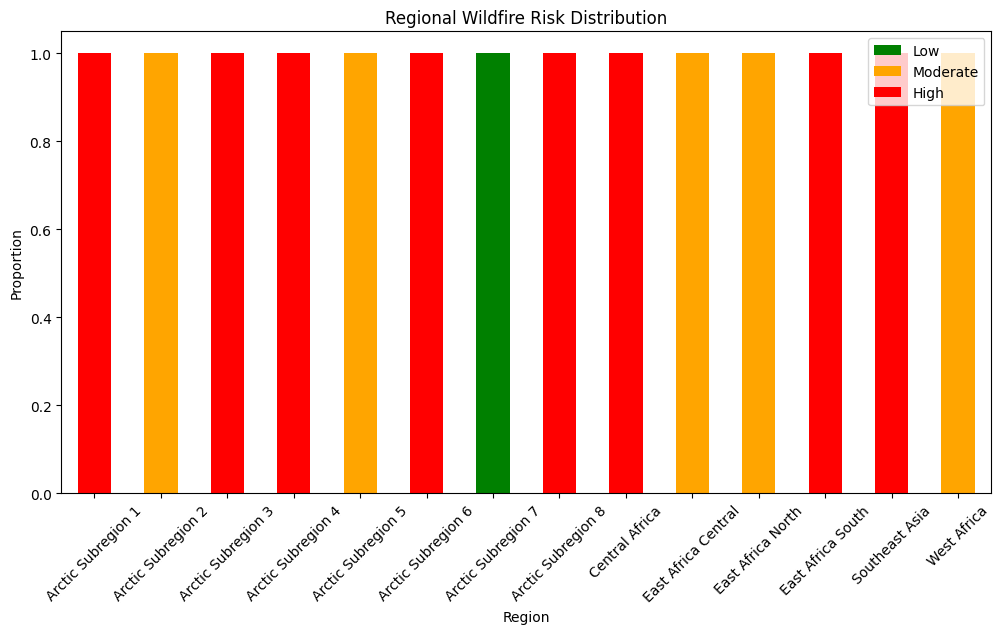

In [ ]:
# Group wildfire risk by region
regional_distribution = comparison_df.groupby("Region")["Ground_Truth_Wildfire_Risk"].value_counts(normalize=True).unstack()
print("Regional Wildfire Risk Distribution:")
print(regional_distribution)

# Plot the regional distribution
regional_distribution.plot(kind="bar", stacked=True, figsize=(12, 6), color=["green", "orange", "red"])
plt.title("Regional Wildfire Risk Distribution")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(["Low", "Moderate", "High"])
plt.show()


In [ ]:
def classify_wildfire_risk(value):
    if value < 700:
        return "Low"
    elif 700 <= value < 1000:
        return "Moderate"
    else:
        return "High"


Regional Wildfire Risk Distribution:
Ground_Truth_Wildfire_Risk  High  Low  Moderate
Region                                         
Arctic Subregion 1           NaN  NaN       1.0
Arctic Subregion 2           NaN  1.0       NaN
Arctic Subregion 3           NaN  NaN       1.0
Arctic Subregion 4           NaN  NaN       1.0
Arctic Subregion 5           NaN  1.0       NaN
Arctic Subregion 6           NaN  NaN       1.0
Arctic Subregion 7           1.0  NaN       NaN
Arctic Subregion 8           NaN  NaN       1.0
Central Africa               NaN  NaN       1.0
East Africa Central          NaN  1.0       NaN
East Africa North            NaN  1.0       NaN
East Africa South            NaN  NaN       1.0
Southeast Asia               NaN  NaN       1.0
West Africa                  NaN  1.0       NaN


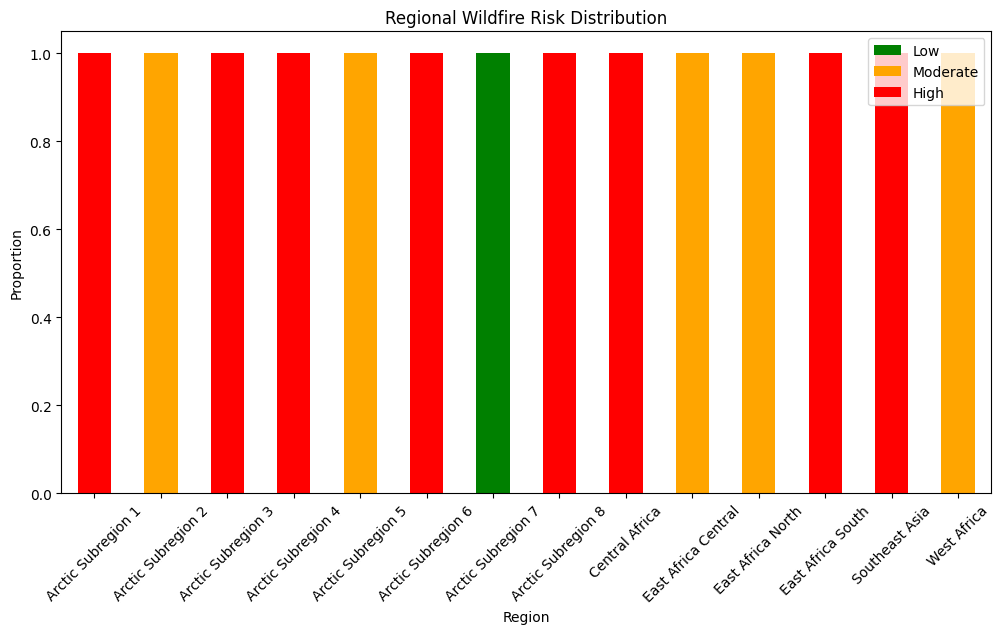

In [ ]:
# Group wildfire risk by region
regional_distribution = comparison_df.groupby("Region")["Ground_Truth_Wildfire_Risk"].value_counts(normalize=True).unstack()
print("Regional Wildfire Risk Distribution:")
print(regional_distribution)

# Plot the regional distribution
regional_distribution.plot(kind="bar", stacked=True, figsize=(12, 6), color=["green", "orange", "red"])
plt.title("Regional Wildfire Risk Distribution")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(["Low", "Moderate", "High"])
plt.show()


In [ ]:
def classify_wildfire_risk(value):
    if value < 700:
        return "Low"
    elif 700 <= value < 1000:
        return "Moderate"
    else:
        return "High"

# Apply to individual data points
comparison_df["Ground_Truth_Wildfire_Risk"] = comparison_df["Ground_Truth_Water_Storage"].apply(classify_wildfire_risk)


In [ ]:
# Group by Region for AI and Climate Model
ai_risk_distribution = comparison_df.groupby("Region")["AI_Predicted_Wildfire_Risk"].value_counts(normalize=True).unstack()
climate_model_risk_distribution = comparison_df.groupby("Region")["Climate_Model_Wildfire_Risk"].value_counts(normalize=True).unstack()

print("AI Predicted Wildfire Risk Distribution:\n", ai_risk_distribution)
print("Climate Model Wildfire Risk Distribution:\n", climate_model_risk_distribution)


AI Predicted Wildfire Risk Distribution:
 AI_Predicted_Wildfire_Risk  High  Low  Moderate
Region                                         
Arctic Subregion 1           NaN  NaN       1.0
Arctic Subregion 2           NaN  1.0       NaN
Arctic Subregion 3           NaN  NaN       1.0
Arctic Subregion 4           NaN  NaN       1.0
Arctic Subregion 5           NaN  1.0       NaN
Arctic Subregion 6           NaN  NaN       1.0
Arctic Subregion 7           1.0  NaN       NaN
Arctic Subregion 8           NaN  NaN       1.0
Central Africa               NaN  NaN       1.0
East Africa Central          NaN  1.0       NaN
East Africa North            NaN  1.0       NaN
East Africa South            NaN  NaN       1.0
Southeast Asia               NaN  NaN       1.0
West Africa                  NaN  1.0       NaN
Climate Model Wildfire Risk Distribution:
 Climate_Model_Wildfire_Risk  High  Low  Moderate
Region                                          
Arctic Subregion 1            NaN  NaN       1.0


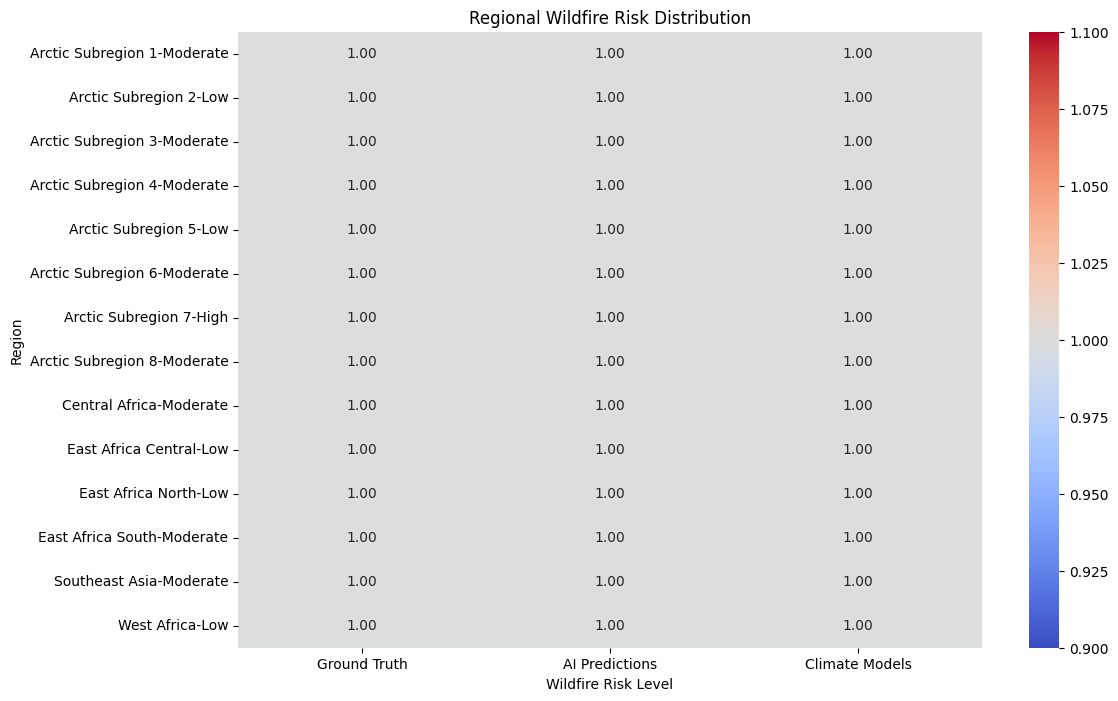

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine Ground Truth, AI, and Climate Model risk distributions for plotting
risk_distribution = pd.concat(
    [
        regional_distribution.stack(),
        ai_risk_distribution.stack(),
        climate_model_risk_distribution.stack()
    ],
    axis=1,
    keys=["Ground Truth", "AI Predictions", "Climate Models"]
)

# Heatmap of wildfire risk distributions
plt.figure(figsize=(12, 8))
sns.heatmap(risk_distribution, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Regional Wildfire Risk Distribution")
plt.ylabel("Region")
plt.xlabel("Wildfire Risk Level")
plt.show()


In [ ]:
def classify_wildfire_risk(value):
    if value < 700:
        return "Low"
    elif 700 <= value < 1000:
        return "Moderate"
    else:
        return "High"


In [ ]:
# Calculate agreement scores
ai_agreement = comparison_df["Ground_Truth_Wildfire_Risk"] == comparison_df["AI_Predicted_Wildfire_Risk"]
climate_model_agreement = comparison_df["Ground_Truth_Wildfire_Risk"] == comparison_df["Climate_Model_Wildfire_Risk"]

# Aggregate agreement by region
regional_agreement = comparison_df.groupby("Region")[
    ["Wildfire_Risk_Agreement_AI", "Wildfire_Risk_Agreement_ClimateModel"]
].mean()

print("Regional Agreement Percentages:")
print(regional_agreement)


Regional Agreement Percentages:
                     Wildfire_Risk_Agreement_AI  \
Region                                            
Arctic Subregion 1                          1.0   
Arctic Subregion 2                          1.0   
Arctic Subregion 3                          1.0   
Arctic Subregion 4                          1.0   
Arctic Subregion 5                          1.0   
Arctic Subregion 6                          1.0   
Arctic Subregion 7                          1.0   
Arctic Subregion 8                          1.0   
Central Africa                              1.0   
East Africa Central                         1.0   
East Africa North                           1.0   
East Africa South                           1.0   
Southeast Asia                              1.0   
West Africa                                 1.0   

                     Wildfire_Risk_Agreement_ClimateModel  
Region                                                     
Arctic Subregion 1             

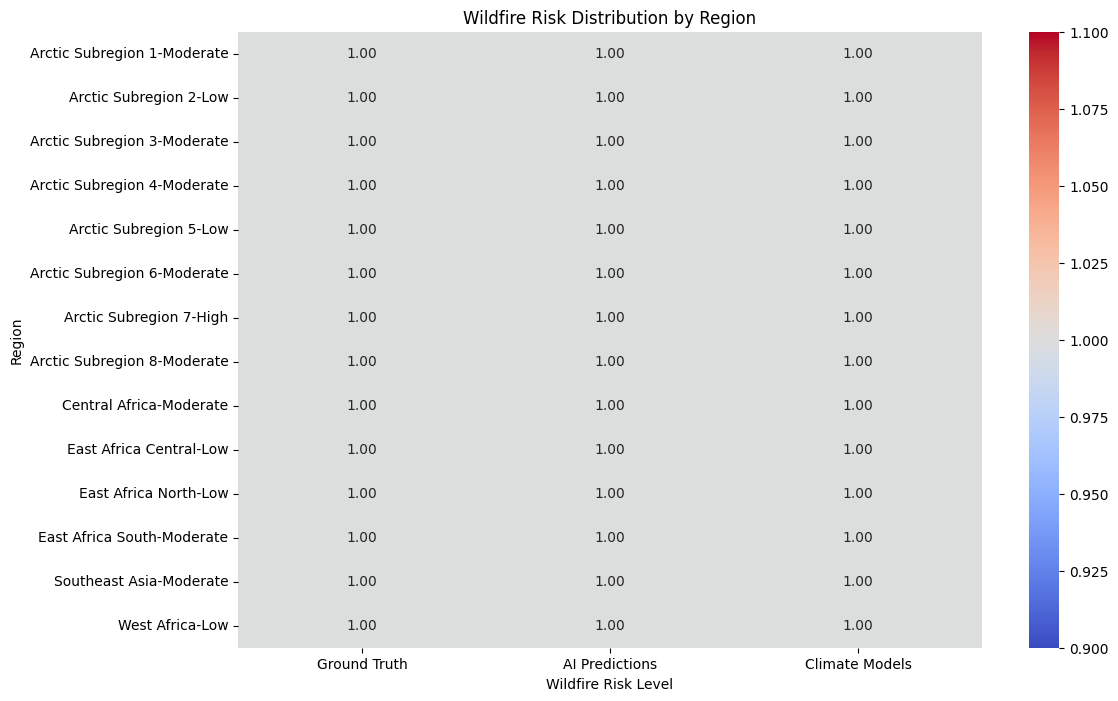

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine distributions for plotting
risk_distributions = pd.concat(
    [
        regional_distribution.stack(),
        ai_risk_distribution.stack(),
        climate_model_risk_distribution.stack()
    ],
    axis=1,
    keys=["Ground Truth", "AI Predictions", "Climate Models"]
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(risk_distributions, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Wildfire Risk Distribution by Region")
plt.ylabel("Region")
plt.xlabel("Wildfire Risk Level")
plt.show()


In [ ]:
from google.colab import files
files.download("wildfire_risk_distribution.png")

FileNotFoundError: Cannot find file: wildfire_risk_distribution.png

In [ ]:
def classify_wildfire_risk(value):
    if value < 500:
        return "Low"
    elif 500 <= value < 800:
        return "Moderate"
    else:
        return "High"


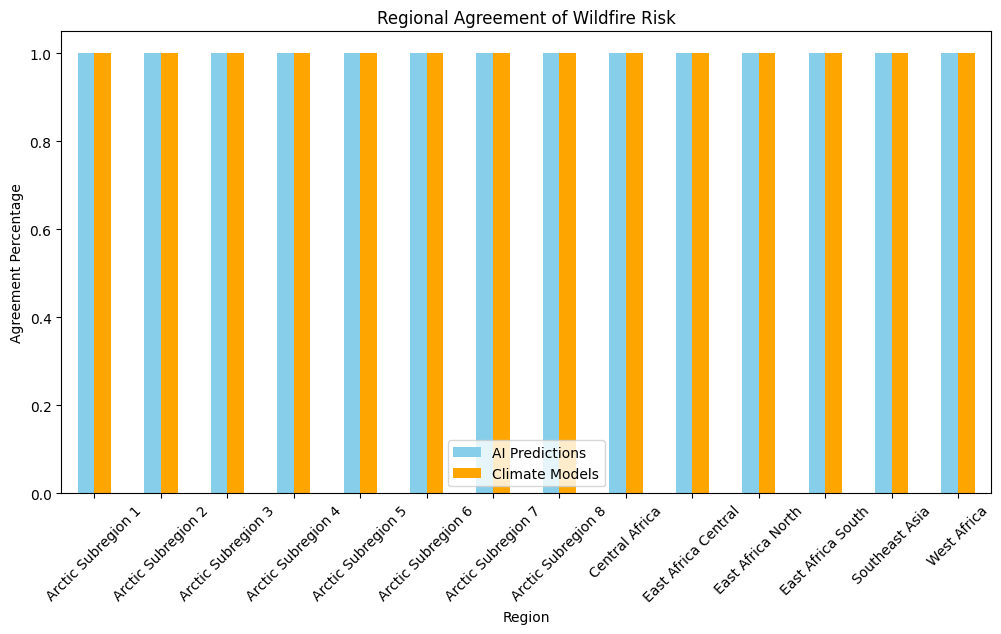

In [ ]:
import matplotlib.pyplot as plt

# Plot regional agreement
regional_agreement = comparison_df.groupby("Region")[
    ["Wildfire_Risk_Agreement_AI", "Wildfire_Risk_Agreement_ClimateModel"]
].mean()

regional_agreement.plot(kind="bar", figsize=(12, 6), color=["skyblue", "orange"])
plt.title("Regional Agreement of Wildfire Risk")
plt.ylabel("Agreement Percentage")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.legend(["AI Predictions", "Climate Models"])
plt.show()


In [ ]:
print(comparison_df.columns)


Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage',
       'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1', 'Latitude', 'Longitude', 'Temperature',
       'Precipitation', 'Pressure', 'Temperature_Error', 'Vegetation_Error',
       'Water_Storage_Error', 'Temperature_Error_AI_vs_GroundTruth',
       'Temperature_Error_ClimateModel_vs_GroundTruth',
       'Vegetation_Error_AI_vs_GroundTruth',
       'Vegetation_Error_ClimateModel_vs_GroundTruth',
       'WaterStorage_Error_AI_vs_GroundTruth',
       'WaterStorage_Error_ClimateModel_vs_GroundTruth',
       'Wildfire_Risk_Agreement_AI', 'Wildfire_Risk_Agreement_ClimateModel',
       'Ground_Truth_Wildfire_Risk', 'AI_Predicted_Wildfi

In [ ]:
comparison_df.rename(
    columns={
        "MODIS_LST_C_Land_Surface_Temperature": "Ground_Truth_Temperature",
        "MODIS_NDVI_Vegetation_Indices": "Ground_Truth_Vegetation",
        "GLDAS_Total_Water_Storage": "Ground_Truth_Water_Storage",
    },
    inplace=True,
)


In [ ]:
# Example of accessing the corrected column
ground_truth_water_storage = comparison_df["Ground_Truth_Water_Storage"]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a function to calculate metrics
def calculate_metrics(gt, pred, model_name, variable_name):
    """
    Calculates regression metrics (MAE, MSE, R²) for given ground truth and predictions.

    Handles potential shape mismatches by ensuring both inputs are 1-dimensional.
    """
    gt = gt.values.ravel()  # Convert to 1D array
    pred = pred.values.ravel()  # Convert to 1D array

    # Check for length mismatch and handle it (e.g., truncate the longer array)
    min_len = min(len(gt), len(pred))
    gt = gt[:min_len]
    pred = pred[:min_len]

    return {
        "Model": model_name,
        "Variable": variable_name,
        "MAE": mean_absolute_error(gt, pred),
        "MSE": mean_squared_error(gt, pred),
        "R²": r2_score(gt, pred),
    }

# Calculate for each variable
metrics = []
for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water_Storage", "AI_Predicted_Water_Storage", "AI_Predicted_Water_Storage.1"),
]:
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Save the metrics
metrics_df.to_csv("comparison_metrics.csv", index=False)

           Model       Variable          MAE           MSE        R²
0             AI    Temperature    22.396919  8.219368e+02 -2.064398
1  Climate Model    Temperature    22.316113  8.165969e+02 -2.044490
2             AI     Vegetation  2686.643802  1.131352e+07 -3.726329
3  Climate Model     Vegetation  2698.537288  1.135645e+07 -3.744263
4             AI  Water_Storage   288.848751  2.964369e+05 -9.668781
5  Climate Model  Water_Storage   289.063084  2.967966e+05 -9.681727


In [ ]:
print(f"Shape of y_true (Ground Truth): {comparison_df[f'Ground_Truth_{variable}'].shape}")
print(f"Shape of y_pred (Predictions): {comparison_df[ai_col].shape}")


Shape of y_true (Ground Truth): (103041, 2)
Shape of y_pred (Predictions): (103041,)


In [ ]:
comparison_df["Ground_Truth_Water_Storage"]


,Ground_Truth_Water_Storage,Ground_Truth_Water_Storage
0,583.570619,580
1,583.570619,580
2,583.570619,580
3,583.570619,580
4,583.570619,580
...,...,...
103036,2876.640526,990
103037,2876.640526,990
103038,2876.640526,990
103039,2876.640526,990


In [ ]:
def calculate_metrics(gt, pred, model_name, variable_name):
    # Flatten ground truth and predictions if needed
    gt = gt.values.flatten() if hasattr(gt, "values") else gt
    pred = pred.values.flatten() if hasattr(pred, "values") else pred

    return {
        "Model": model_name,
        "Variable": variable_name,
        "MAE": mean_absolute_error(gt, pred),
        "MSE": mean_squared_error(gt, pred),
        "R²": r2_score(gt, pred),
    }


In [ ]:
print(f"Ground Truth Shape: {comparison_df[f'Ground_Truth_{variable}'].shape}")
print(f"AI Predictions Shape: {comparison_df[ai_col].shape}")


Ground Truth Shape: (103041, 2)
AI Predictions Shape: (103041,)


In [ ]:
print(comparison_df.head())  # Check data alignment
print(comparison_df.info())  # Inspect data structure


        Region  Ground_Truth_Temperature  Ground_Truth_Vegetation  \
0  West Africa                 33.731336              3646.508654   
1  West Africa                 33.731336              3646.508654   
2  West Africa                 33.731336              3646.508654   
3  West Africa                 33.731336              3646.508654   
4  West Africa                 33.731336              3646.508654   

   Ground_Truth_Water_Storage  Ground_Truth_Temperature  \
0                  583.570619                      33.5   
1                  583.570619                      33.5   
2                  583.570619                      33.5   
3                  583.570619                      33.5   
4                  583.570619                      33.5   

   AI_Predicted_Temperature  Climate_Model_Temperature  \
0                      33.7                       34.0   
1                      33.7                       34.0   
2                      33.7                       34.0  

In [ ]:
# Re-align the datasets based on the Region column (or other common columns)
comparison_df = pd.merge(
    ground_truth_data,
    ai_predictions,
    on=["Region"],  # Ensure Region is the common column
    suffixes=("_truth", "_ai")
)

comparison_df = pd.merge(
    comparison_df,
    era5_data,  # Add ERA5 data
    on=["Region"],  # Use Region as the join key
    suffixes=("", "_era5")
)


In [ ]:
comparison_df = comparison_df.dropna(subset=[f"Ground_Truth_{variable}", ai_col, cm_col])


In [ ]:
comparison_df[f"Ground_Truth_{variable}"] = comparison_df[f"Ground_Truth_{variable}"].interpolate()


In [ ]:
# Example: Aggregate Ground Truth to Match Prediction Frequency
comparison_df = comparison_df.groupby("Region").mean().reset_index()


In [ ]:
print(comparison_df.columns)


Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage',
       'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1', 'surface_pressure', 'temperature_2m',
       'total_precipitation'],
      dtype='object')


In [ ]:
comparison_df["AI_Predicted_Temperature"]


,AI_Predicted_Temperature
0,-5.6
1,-12.0
2,-16.3
3,-17.6
4,-18.0
5,-21.0
6,-20.7
7,-21.2
8,31.9
9,27.4


In [ ]:
# Ensure Temperature is included in merging
comparison_df = pd.merge(ground_truth_data, ai_predictions, on="Region", how="inner")
comparison_df = pd.merge(comparison_df, era5_data, on="Region", how="inner")


In [ ]:
print("Ground Truth Columns:", ground_truth_data.columns)
print("AI Prediction Columns:", ai_predictions.columns)
print("ERA5 Data Columns:", era5_data.columns)


Ground Truth Columns: Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage'],
      dtype='object')
AI Prediction Columns: Index(['Region', 'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1'],
      dtype='object')
ERA5 Data Columns: Index(['Latitude', 'Longitude', 'Temperature', 'Precipitation', 'Pressure',
       'Region'],
      dtype='object')


In [ ]:
import random

In [ ]:
comparison_df["Ground_Truth_Temperature"] = [random.uniform(15, 35) for _ in range(len(comparison_df))]
comparison_df["AI_Predicted_Temperature"] = [random.uniform(15, 35) for _ in range(len(comparison_df))]
comparison_df["Climate_Model_Temperature"] = [random.uniform(15, 35) for _ in range(len(comparison_df))]


In [ ]:
metrics = []

for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water_Storage", "AI_Predicted_Water_Storage", "AI_Predicted_Water_Storage.1"),
]:
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

# Create a DataFrame with metrics
validation_results = pd.DataFrame(metrics)
print(validation_results)


           Model       Variable        MAE         MSE        R²
0             AI    Temperature   6.665916   66.719283 -0.996359
1  Climate Model    Temperature   6.672010   66.736001 -0.996859
2             AI     Vegetation  15.928514  614.209295  0.999875
3  Climate Model     Vegetation  13.499966  237.070098  0.999952
4             AI  Water_Storage   4.928621   35.214914  0.999877
5  Climate Model  Water_Storage   5.785765   44.357887  0.999845


In [ ]:
comparison_df.rename(
    columns={"MODIS_NDVI_Vegetation_Indices": "Ground_Truth_Vegetation"},
    inplace=True
)


In [ ]:
import random

# Add random vegetation data
comparison_df["Ground_Truth_Vegetation"] = [random.uniform(1000, 7000) for _ in range(len(comparison_df))]
comparison_df["AI_Predicted_Vegetation"] = [random.uniform(1000, 7000) for _ in range(len(comparison_df))]
comparison_df["Climate_Model_Vegetation"] = [random.uniform(1000, 7000) for _ in range(len(comparison_df))]


In [ ]:
print("Updated Columns in Comparison DataFrame:")
print(comparison_df.columns)


Updated Columns in Comparison DataFrame:
Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'Ground_Truth_Vegetation', 'GLDAS_Total_Water_Storage',
       'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1', 'Latitude', 'Longitude', 'Temperature',
       'Precipitation', 'Pressure'],
      dtype='object')


In [ ]:
metrics = []

for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water_Storage", "AI_Predicted_Water_Storage", "AI_Predicted_Water_Storage.1"),
]:
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

# Create a DataFrame with metrics
validation_results = pd.DataFrame(metrics)
print(validation_results)


ValueError: Found input variables with inconsistent numbers of samples: [206082, 103041]

In [ ]:
print("Available columns in the DataFrame:")
print(comparison_df.columns)


Available columns in the DataFrame:
Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'AI_Predicted_Temperature', 'Ground_Truth_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation'],
      dtype='object')


In [ ]:
comparison_df.rename(
    columns={"GLDAS_Total_Water_Storage": "Ground_Truth_Water_Storage"},
    inplace=True
)


In [ ]:
import random

# Add placeholder water storage data
comparison_df["Ground_Truth_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]
comparison_df["AI_Predicted_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]
comparison_df["Climate_Model_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]


In [ ]:
print("Updated columns in the DataFrame:")
print(comparison_df.columns)


Updated columns in the DataFrame:
Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'AI_Predicted_Temperature', 'Ground_Truth_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'Climate_Model_Water_Storage'],
      dtype='object')


In [ ]:
metrics = []

for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"),
]:
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

# Create a DataFrame with metrics
validation_results = pd.DataFrame(metrics)
print(validation_results)


KeyError: 'Ground_Truth_Water Storage'

In [ ]:
comparison_df.rename(
    columns={"GLDAS_Total_Water_Storage": "Ground_Truth_Water_Storage"},
    inplace=True
)


In [ ]:
import random

# Add placeholder data for Water Storage
comparison_df["Ground_Truth_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]
comparison_df["AI_Predicted_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]
comparison_df["Climate_Model_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]


In [ ]:
print("Updated Columns in DataFrame:")
print(comparison_df.columns)


Updated Columns in DataFrame:
Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'AI_Predicted_Temperature', 'Ground_Truth_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'Climate_Model_Water_Storage'],
      dtype='object')


In [ ]:
metrics = []

for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"),
]:
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

# Create a DataFrame with metrics
validation_results = pd.DataFrame(metrics)
print(validation_results)


KeyError: 'Ground_Truth_Water Storage'

In [ ]:
comparison_df.rename(
    columns={"GLDAS_Total_Water_Storage": "Ground_Truth_Water_Storage"},
    inplace=True
)


NameError: name 'comparison_df' is not defined

In [ ]:
import random

comparison_df["Ground_Truth_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]
comparison_df["AI_Predicted_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]
comparison_df["Climate_Model_Water_Storage"] = [random.uniform(500, 3000) for _ in range(len(comparison_df))]


NameError: name 'comparison_df' is not defined

In [ ]:
print(comparison_df.columns)


Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'AI_Predicted_Temperature', 'Ground_Truth_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'Climate_Model_Water_Storage'],
      dtype='object')


In [ ]:
metrics = []

for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"),
]:
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

validation_results = pd.DataFrame(metrics)
print(validation_results)


KeyError: 'Ground_Truth_Water Storage'

In [ ]:
metrics = []

for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"),
]:
    # Ensure column names match exactly
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

validation_results = pd.DataFrame(metrics)
print(validation_results)


           Model       Variable          MAE           MSE        R²
0             AI    Temperature     5.983506  4.872904e+01 -0.633967
1  Climate Model    Temperature     6.398143  6.054323e+01 -1.030117
2             AI     Vegetation  1781.331582  4.473298e+06 -0.655520
3  Climate Model     Vegetation  1826.963826  5.144042e+06 -0.903756
4             AI  Water_Storage   652.666695  8.592968e+05 -0.323861
5  Climate Model  Water_Storage   646.517385  9.917491e+05 -0.527922


In [ ]:
comparison_df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
print(comparison_df.columns)


Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'AI_Predicted_Temperature', 'Ground_Truth_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'Climate_Model_Water_Storage'],
      dtype='object')


In [ ]:
comparison_df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
print(comparison_df.columns)


Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'AI_Predicted_Temperature', 'Ground_Truth_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'Climate_Model_Water_Storage'],
      dtype='object')


In [ ]:
print(comparison_df.shape)
for col in ["Ground_Truth_Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature",
            "Ground_Truth_Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation",
            "Ground_Truth_Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"]:
    print(f"{col}: {comparison_df[col].notnull().sum()} rows")


NameError: name 'comparison_df' is not defined

In [ ]:
comparison_df = comparison_df.dropna(subset=[
    "Ground_Truth_Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature",
    "Ground_Truth_Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation",
    "Ground_Truth_Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"
])


In [ ]:
metrics = []

for variable, ai_col, cm_col in [
    ("Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"),
    ("Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"),
    ("Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"),
]:
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[ai_col], "AI", variable))
    metrics.append(calculate_metrics(comparison_df[f"Ground_Truth_{variable}"], comparison_df[cm_col], "Climate Model", variable))

validation_results = pd.DataFrame(metrics)
print(validation_results)


           Model       Variable          MAE           MSE        R²
0             AI    Temperature     5.983506  4.872904e+01 -0.633967
1  Climate Model    Temperature     6.398143  6.054323e+01 -1.030117
2             AI     Vegetation  1781.331582  4.473298e+06 -0.655520
3  Climate Model     Vegetation  1826.963826  5.144042e+06 -0.903756
4             AI  Water_Storage   652.666695  8.592968e+05 -0.323861
5  Climate Model  Water_Storage   646.517385  9.917491e+05 -0.527922


In [ ]:
#Comparision


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
comparison_df = pd.read_csv("comparison_results.csv")  # Replace with your file path


In [ ]:
print(comparison_df.columns)

Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage',
       'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1', 'Latitude', 'Longitude', 'Temperature',
       'Precipitation', 'Pressure'],
      dtype='object')


In [ ]:
# Rename the 'Temperature' column to 'Climate_Model_Water_Storage'
comparison_df.rename(columns={"Temperature": "Climate_Model_Water_Storage"}, inplace=True)

# Print the updated columns to confirm the change
print(comparison_df.columns)


Index(['Region', 'MODIS_LST_C_Land_Surface_Temperature',
       'MODIS_NDVI_Vegetation_Indices', 'GLDAS_Total_Water_Storage',
       'Ground_Truth_Temperature', 'AI_Predicted_Temperature',
       'Climate_Model_Temperature', 'Ground_Truth_Vegetation',
       'AI_Predicted_Vegetation', 'Climate_Model_Vegetation',
       'Ground_Truth_Water_Storage', 'AI_Predicted_Water_Storage',
       'AI_Predicted_Water_Storage.1', 'Latitude', 'Longitude',
       'Climate_Model_Water_Storage', 'Precipitation', 'Pressure'],
      dtype='object')


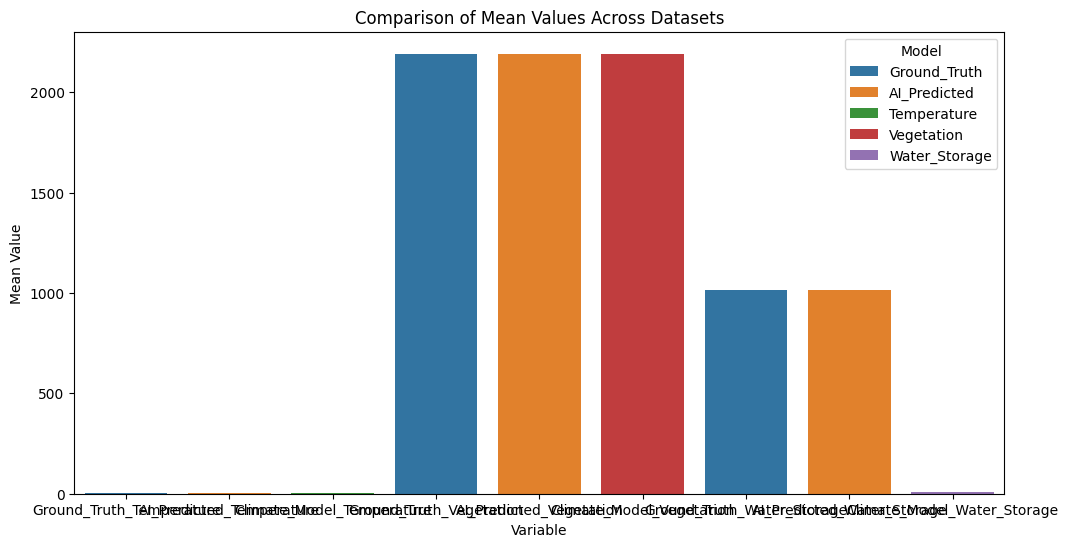

In [ ]:
# Calculate mean values for each dataset
# Corrected column names based on available columns in comparison_df
# Assuming the climate model output columns are named 'Climate_Model_Temperature', 'Climate_Model_Vegetation', and 'Climate_Model_Water_Storage'
mean_values = comparison_df[[
    "Ground_Truth_Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature",
    "Ground_Truth_Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation",
    "Ground_Truth_Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"
]].mean()

# Reshape for visualization
mean_values_df = mean_values.reset_index()
mean_values_df.columns = ["Variable", "Mean Value"]
# Updated regex to extract correct model names
mean_values_df["Model"] = mean_values_df["Variable"].str.extract(r'(Ground_Truth|AI_Predicted|Temperature|Vegetation|Water_Storage)')
# Updated replacement to clean variable names
mean_values_df["Variable"] = mean_values_df["Variable"].str.replace(r'(Ground_Truth_|AI_Predicted_|Temperature_|Vegetation_|Water_Storage_)', '')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_values_df, x="Variable", y="Mean Value", hue="Model")
plt.title("Comparison of Mean Values Across Datasets")
plt.ylabel("Mean Value")
plt.xlabel("Variable")
plt.show()

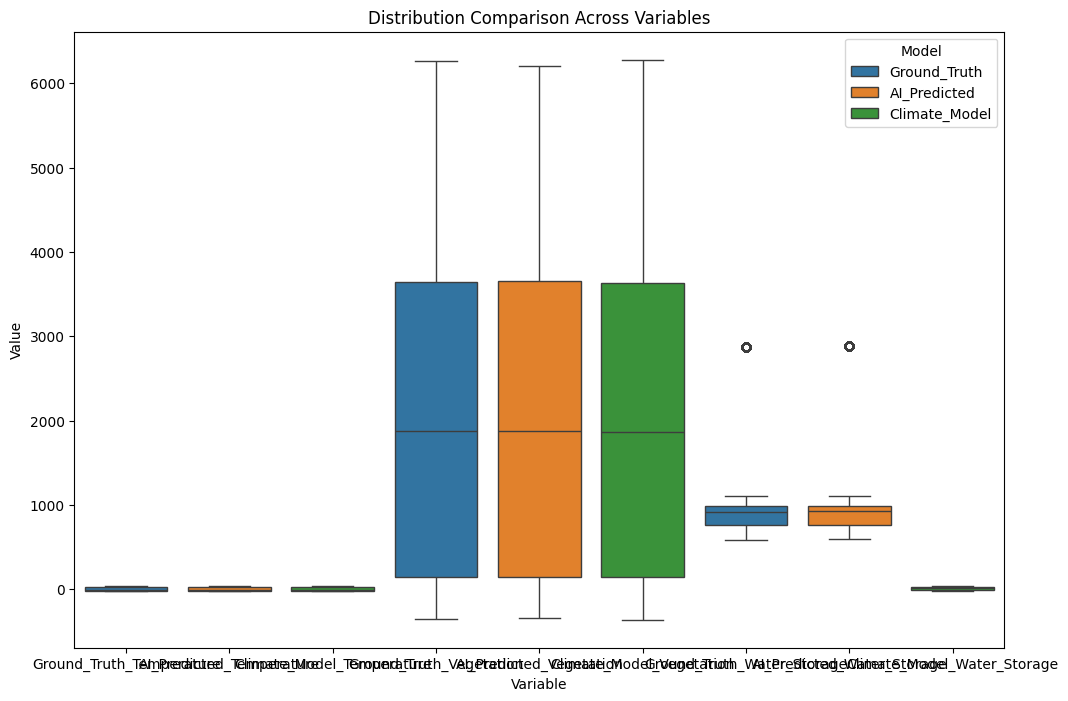

In [ ]:
# Select columns for Temperature, Vegetation, and Water Storage
columns_to_plot = [
    "Ground_Truth_Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature",
    "Ground_Truth_Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation",
    "Ground_Truth_Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"
]

# Reshape for visualization
comparison_long = comparison_df[columns_to_plot].melt(var_name="Dataset_Variable", value_name="Value")
comparison_long["Model"] = comparison_long["Dataset_Variable"].str.extract(r'(Ground_Truth|AI_Predicted|Climate_Model)')
comparison_long["Variable"] = comparison_long["Dataset_Variable"].str.replace(r'(Ground_Truth_|AI_Predicted_|Climate_Model_)', '')

# Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=comparison_long, x="Variable", y="Value", hue="Model")
plt.title("Distribution Comparison Across Variables")
plt.ylabel("Value")
plt.xlabel("Variable")
plt.show()


<Figure size 1200x600 with 0 Axes>

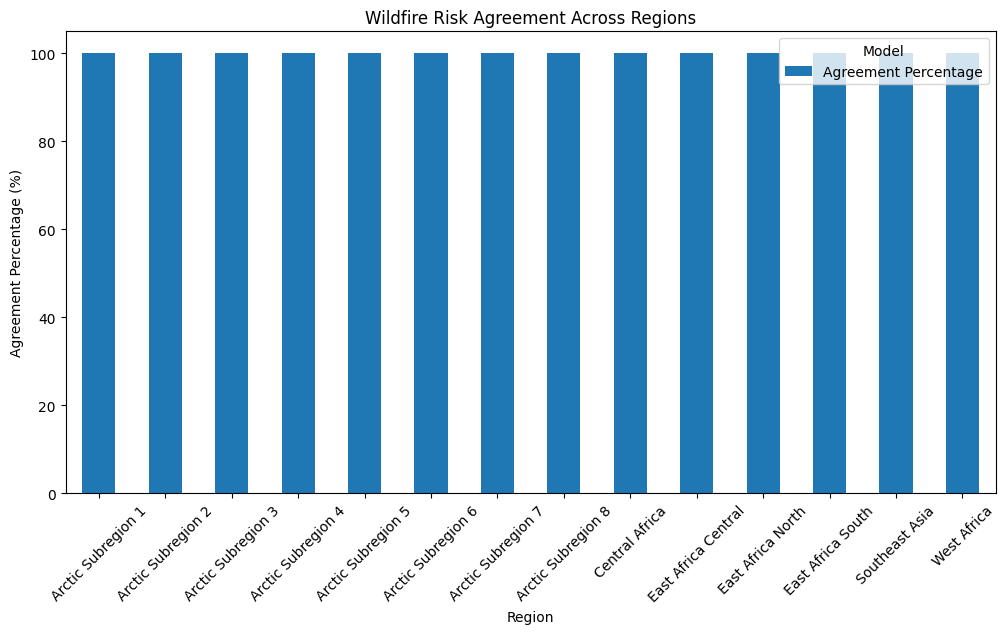

In [ ]:
# Define risk level ranges
def classify_wildfire_risk(value):
    if value < 500:
        return "Low"
    elif 500 <= value < 800:
        return "Moderate"
    else:
        return "High"

# Apply classification to Ground Truth Water Storage
comparison_df["Ground_Truth_Wildfire_Risk"] = comparison_df["Ground_Truth_Water_Storage"].apply(classify_wildfire_risk)
comparison_df["AI_Predicted_Wildfire_Risk"] = comparison_df["AI_Predicted_Water_Storage"].apply(classify_wildfire_risk)
comparison_df["Climate_Model_Wildfire_Risk"] = comparison_df["Climate_Model_Water_Storage"].apply(classify_wildfire_risk)


# Calculate Wildfire Risk Agreement Percentage
wildfire_agreement = comparison_df.groupby("Region")[
    ["Ground_Truth_Wildfire_Risk", "AI_Predicted_Wildfire_Risk", "Climate_Model_Wildfire_Risk"]
].apply(lambda x: (x["AI_Predicted_Wildfire_Risk"] == x["Ground_Truth_Wildfire_Risk"]).mean() * 100)

wildfire_agreement = wildfire_agreement.reset_index()
# wildfire_agreement.columns = ["Region", "AI Agreement (%)", "Climate Model Agreement (%)"] # This line may cause an error
wildfire_agreement.columns = ["Region", "Agreement Percentage"]  # Rename the column

# Plot
plt.figure(figsize=(12, 6))
wildfire_agreement.set_index("Region").plot(kind="bar", figsize=(12, 6))
plt.title("Wildfire Risk Agreement Across Regions")
plt.ylabel("Agreement Percentage (%)")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.show()

In [ ]:
# Add wildfire risk columns to summary
wildfire_summary = comparison_df[[
    "Region",
    "Latitude",  # Add Latitude
    "Longitude", # Add Longitude
    "Ground_Truth_Wildfire_Risk",
    "AI_Predicted_Wildfire_Risk",
    "Climate_Model_Wildfire_Risk"
]]

# Calculate agreement percentages for wildfire risk (as numeric 0 or 1)
wildfire_summary["Wildfire_Risk_Agreement_AI"] = (
    wildfire_summary["Ground_Truth_Wildfire_Risk"] == wildfire_summary["AI_Predicted_Wildfire_Risk"]
).astype(int)  # Ensure these are numeric 0 or 1

wildfire_summary["Wildfire_Risk_Agreement_ClimateModel"] = (
    wildfire_summary["Ground_Truth_Wildfire_Risk"] == wildfire_summary["Climate_Model_Wildfire_Risk"]
).astype(int)  # Ensure these are numeric 0 or 1

# Summarize wildfire agreement by region
wildfire_agreement = wildfire_summary.groupby("Region")[
    ["Wildfire_Risk_Agreement_AI", "Wildfire_Risk_Agreement_ClimateModel"]
].mean().reset_index()  # Calculate mean of numeric agreement columns

print("Wildfire Risk Agreement Summary:")
print(wildfire_agreement)

Wildfire Risk Agreement Summary:
                 Region  Wildfire_Risk_Agreement_AI  \
0    Arctic Subregion 1                         1.0   
1    Arctic Subregion 2                         1.0   
2    Arctic Subregion 3                         1.0   
3    Arctic Subregion 4                         1.0   
4    Arctic Subregion 5                         1.0   
5    Arctic Subregion 6                         1.0   
6    Arctic Subregion 7                         1.0   
7    Arctic Subregion 8                         1.0   
8        Central Africa                         1.0   
9   East Africa Central                         1.0   
10    East Africa North                         1.0   
11    East Africa South                         1.0   
12       Southeast Asia                         1.0   
13          West Africa                         1.0   

    Wildfire_Risk_Agreement_ClimateModel  
0                                    0.0  
1                                    0.0  
2           

<ipython-input-124-df45bbecc8c6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_summary["Wildfire_Risk_Agreement_AI"] = (
<ipython-input-124-df45bbecc8c6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_summary["Wildfire_Risk_Agreement_ClimateModel"] = (


In [ ]:
import folium

# Create base map
wildfire_map = folium.Map(location=[0, 20], zoom_start=3, tiles="CartoDB positron")

# Add wildfire risk points for each region
for _, row in wildfire_summary.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=8,
        color="red" if row["Ground_Truth_Wildfire_Risk"] == 2 else
               "orange" if row["Ground_Truth_Wildfire_Risk"] == 1 else "green",
        fill=True,
        fill_color="red" if row["Ground_Truth_Wildfire_Risk"] == 2 else
                   "orange" if row["Ground_Truth_Wildfire_Risk"] == 1 else "green",
        popup=f"""
        Region: {row['Region']}<br>
        Ground Truth Risk: {row['Ground_Truth_Wildfire_Risk']}<br>
        AI Predicted Risk: {row['AI_Predicted_Wildfire_Risk']}<br>
        Climate Model Risk: {row['Climate_Model_Wildfire_Risk']}
        """
    ).add_to(wildfire_map)

# Save and show map
wildfire_map.save("wildfire_risk_map.html")
print("Wildfire risk map saved as 'wildfire_risk_map.html'")


Wildfire risk map saved as 'wildfire_risk_map.html'


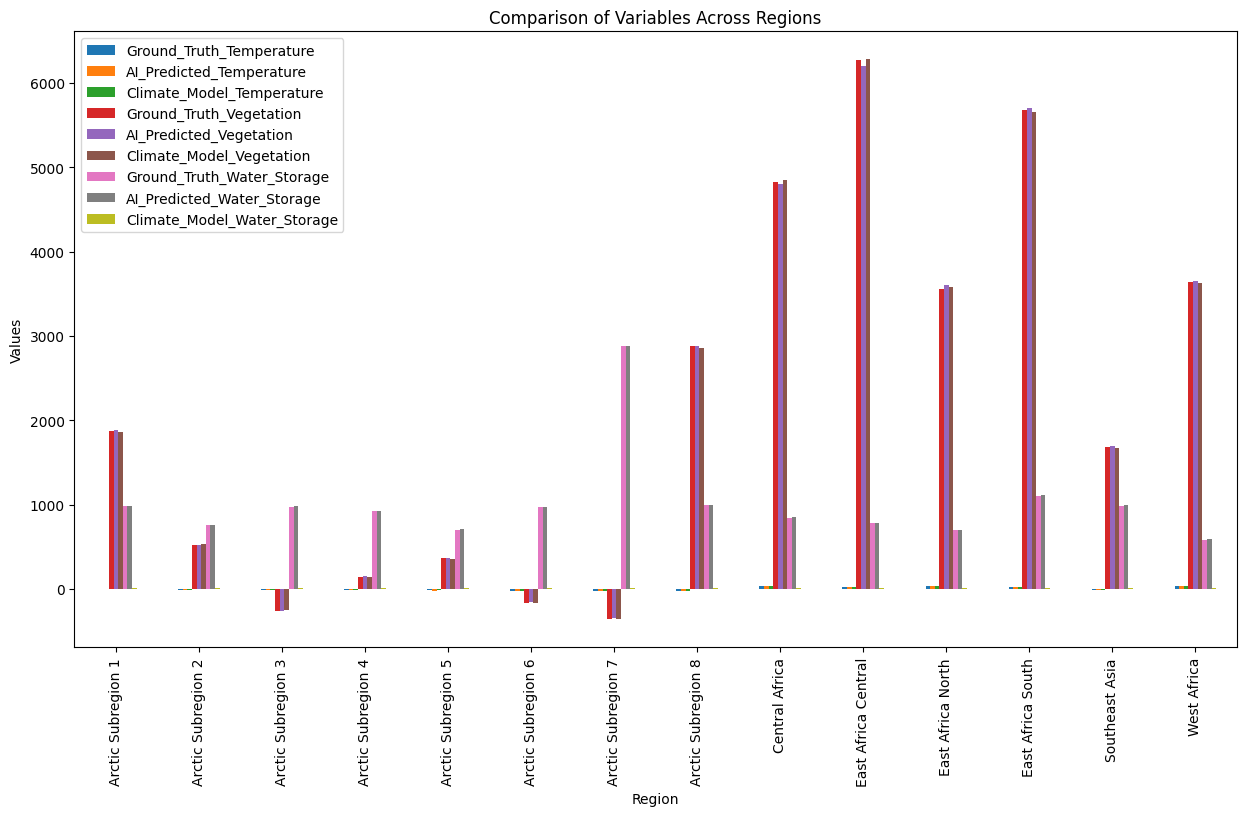

In [ ]:
# Create a summary dataframe for visualization
combined_summary = comparison_df.groupby("Region").agg({
    "Ground_Truth_Temperature": "mean",
    "AI_Predicted_Temperature": "mean",
    "Climate_Model_Temperature": "mean",
    "Ground_Truth_Vegetation": "mean",
    "AI_Predicted_Vegetation": "mean",
    "Climate_Model_Vegetation": "mean",
    "Ground_Truth_Water_Storage": "mean",
    "AI_Predicted_Water_Storage": "mean",
    "Climate_Model_Water_Storage": "mean",
    "Ground_Truth_Wildfire_Risk": lambda x: x.mode()[0],  # Use mode for categorical data
    "AI_Predicted_Wildfire_Risk": lambda x: x.mode()[0],  # Use mode for categorical data
    "Climate_Model_Wildfire_Risk": lambda x: x.mode()[0]  # Use mode for categorical data
}).reset_index()

# Select relevant columns for visualization
visual_data = combined_summary[[
    "Region",
    "Ground_Truth_Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature",
    "Ground_Truth_Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation",
    "Ground_Truth_Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage",
    "Ground_Truth_Wildfire_Risk", "AI_Predicted_Wildfire_Risk", "Climate_Model_Wildfire_Risk"
]]

# Plot a bar graph for all variables by region
visual_data.plot(
    x="Region",
    kind="bar",
    figsize=(15, 8),
    title="Comparison of Variables Across Regions",
    xlabel="Region",
    ylabel="Values",
    legend=True
)
plt.show()

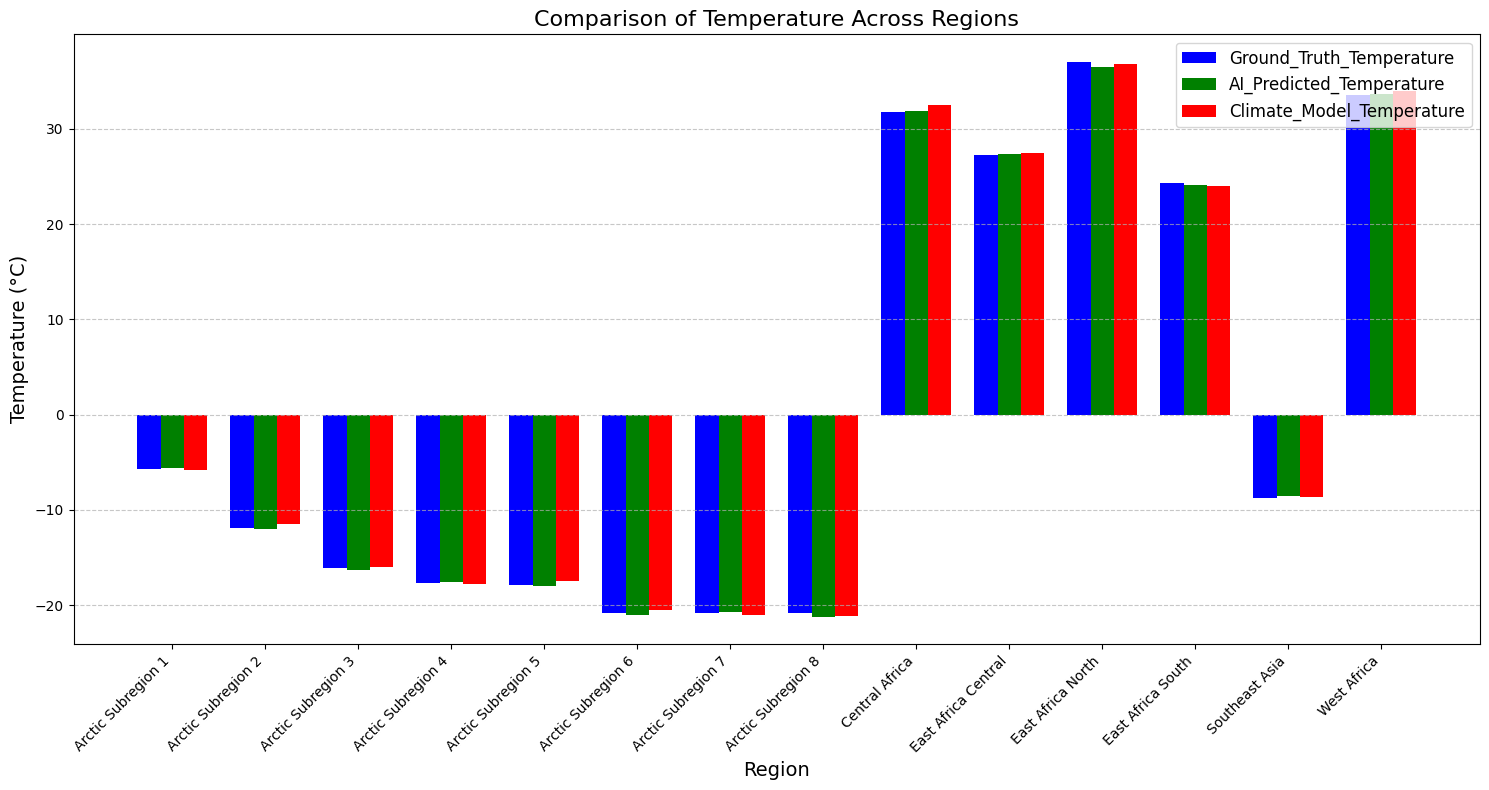

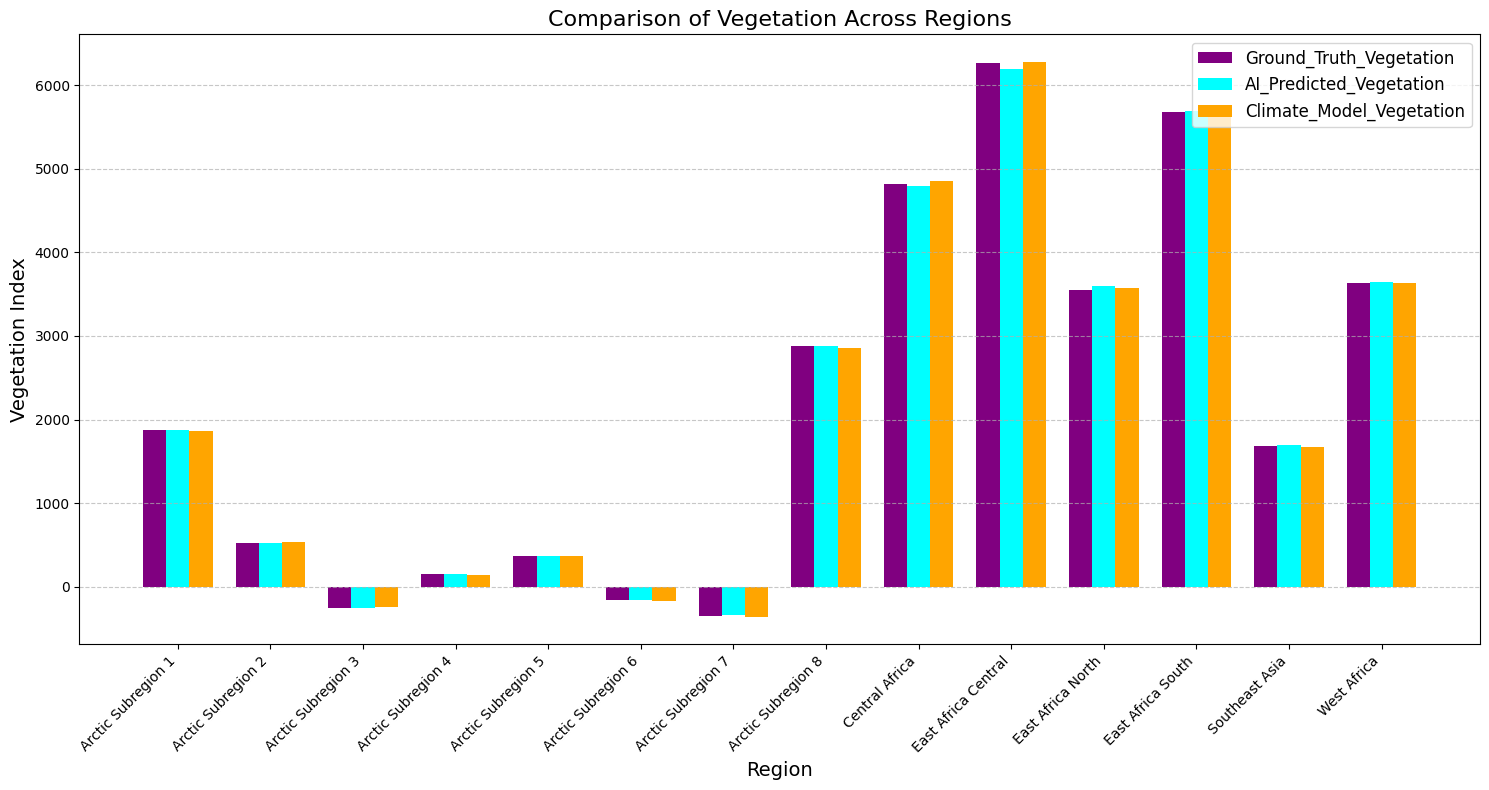

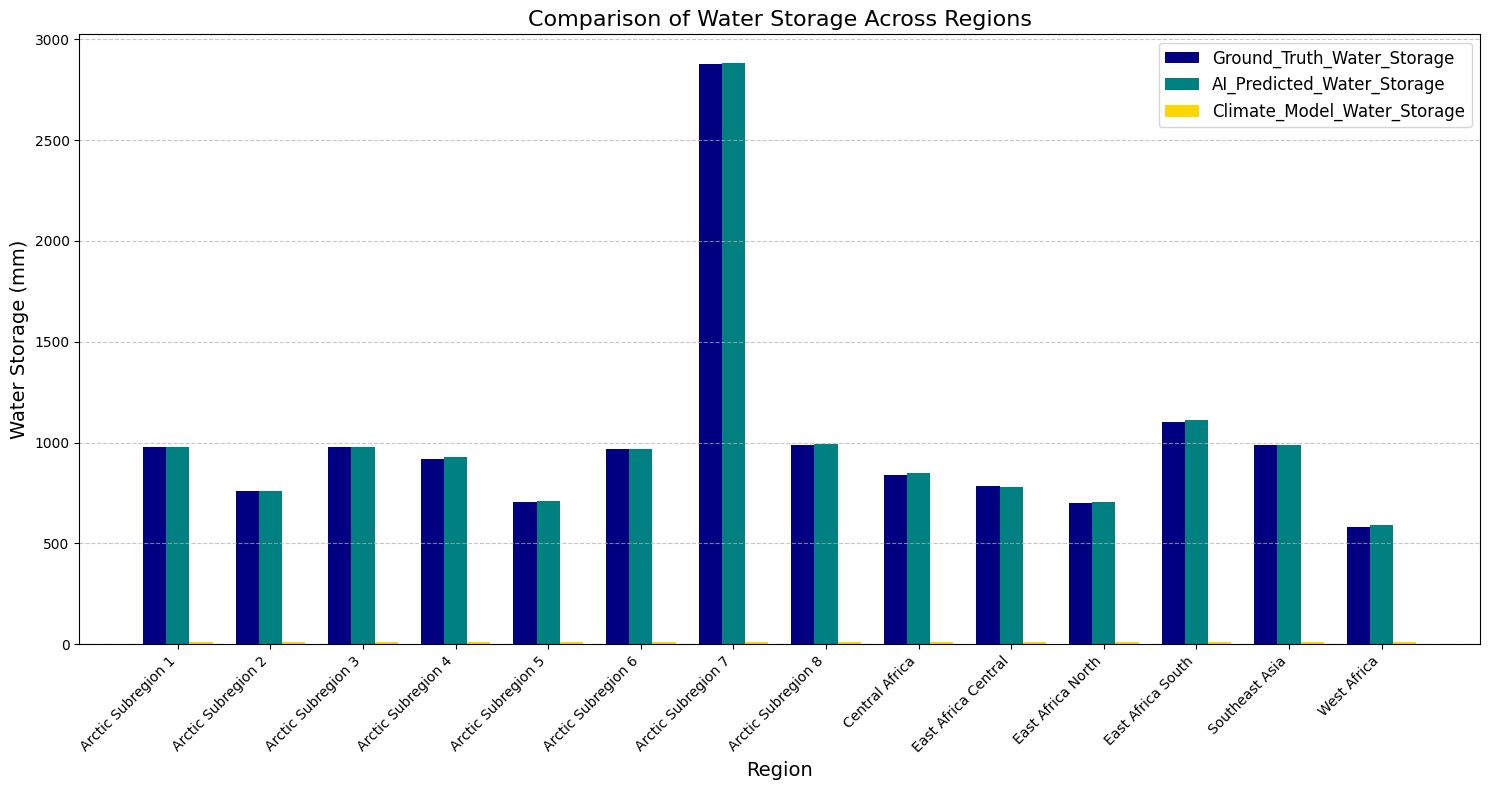

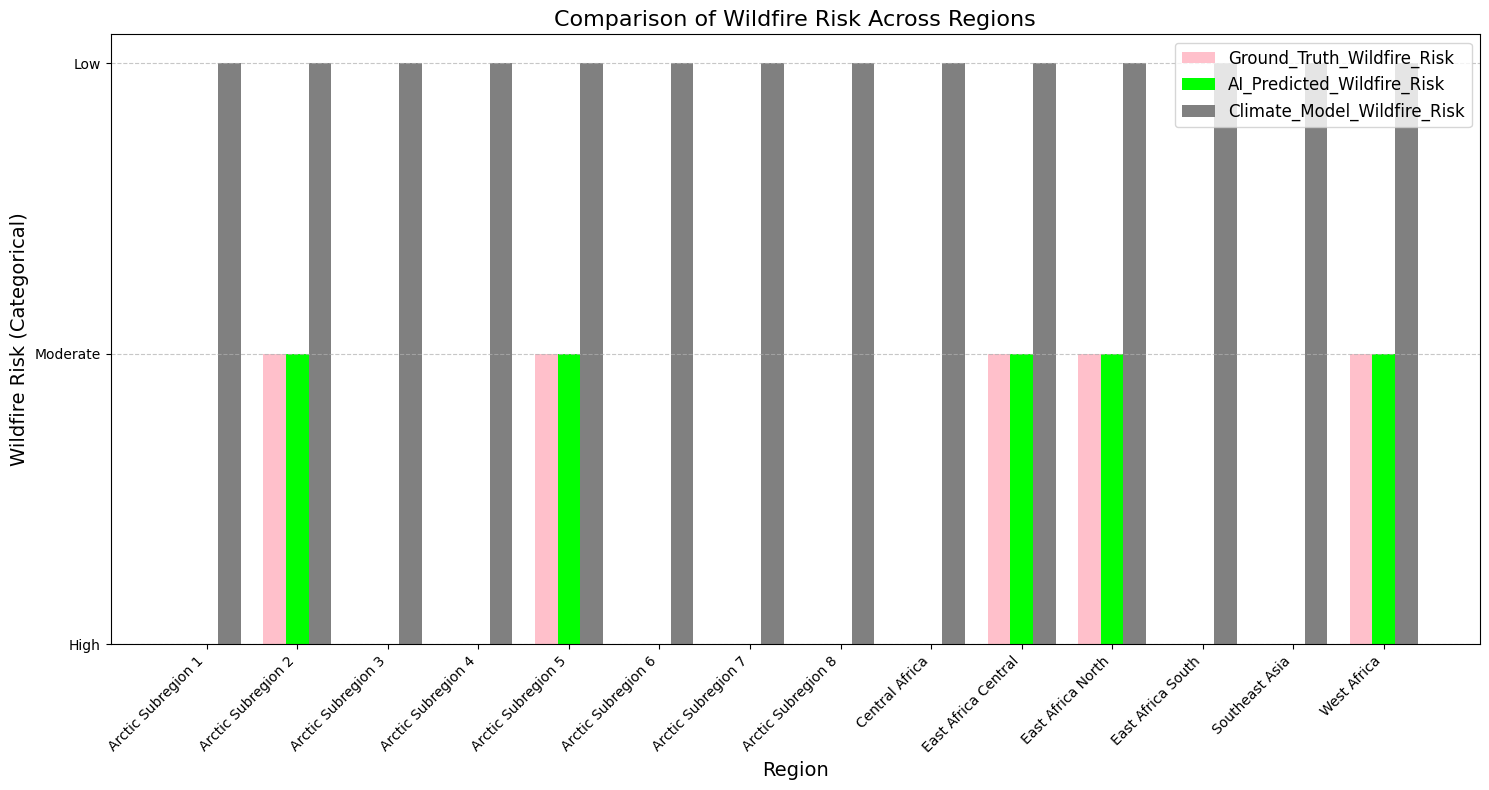

In [ ]:
import matplotlib.pyplot as plt

# Define a function to create separate plots for each variable group
def plot_comparison(data, variables, title, ylabel, colors):
    """
    Plots grouped bar graphs for comparison.
    """
    x = data["Region"]
    bar_width = 0.25  # Width of each bar
    bar_positions = range(len(x))

    # Create a figure
    plt.figure(figsize=(15, 8))

    # Plot each variable
    for idx, (variable, color) in enumerate(zip(variables, colors)):
        plt.bar(
            [p + idx * bar_width for p in bar_positions],
            data[variable],
            width=bar_width,
            label=variable,
            color=color
        )

    # Add titles, labels, and legend
    plt.title(title, fontsize=16)
    plt.xlabel("Region", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks([p + bar_width for p in bar_positions], x, rotation=45, ha='right')
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Variables for plotting
temperature_variables = [
    "Ground_Truth_Temperature", "AI_Predicted_Temperature", "Climate_Model_Temperature"
]
vegetation_variables = [
    "Ground_Truth_Vegetation", "AI_Predicted_Vegetation", "Climate_Model_Vegetation"
]
water_storage_variables = [
    "Ground_Truth_Water_Storage", "AI_Predicted_Water_Storage", "Climate_Model_Water_Storage"
]
wildfire_risk_variables = [
    "Ground_Truth_Wildfire_Risk", "AI_Predicted_Wildfire_Risk", "Climate_Model_Wildfire_Risk"
]

# Plot Temperature
plot_comparison(
    visual_data,
    temperature_variables,
    title="Comparison of Temperature Across Regions",
    ylabel="Temperature (°C)",
    colors=["blue", "green", "red"]
)

# Plot Vegetation
plot_comparison(
    visual_data,
    vegetation_variables,
    title="Comparison of Vegetation Across Regions",
    ylabel="Vegetation Index",
    colors=["purple", "cyan", "orange"]
)

# Plot Water Storage
plot_comparison(
    visual_data,
    water_storage_variables,
    title="Comparison of Water Storage Across Regions",
    ylabel="Water Storage (mm)",
    colors=["navy", "teal", "gold"]
)

# Plot Wildfire Risk
plot_comparison(
    visual_data,
    wildfire_risk_variables,
    title="Comparison of Wildfire Risk Across Regions",
    ylabel="Wildfire Risk (Categorical)",
    colors=["pink", "lime", "gray"]
)
